In [1]:
%matplotlib inline

In [1]:
import datetime
import pandas as pd
import numpy as np
import datetime

In [45]:
import catboost
from catboost import CatBoostClassifier, Pool, cv
from lightgbm import LGBMClassifier
from hyperopt import fmin, tpe, hp

In [3]:
import tqdm

In [4]:
import sklearn.model_selection
from sklearn import model_selection , metrics   #Additional scklearn functions
from sklearn.metrics import roc_auc_score

In [5]:
import os
import sys

module_path = os.path.abspath(os.path.join('..'))

if module_path not in sys.path:
    sys.path.append(module_path)

In [6]:
from importlib import reload
import src.home_service
reload(src.home_service)
from src.home_service import *

## import and parameters

In [17]:
# methode 4 is the best impute strategy (+1.5 AUC better than methode 3)
imput_strategy = 4

In [25]:
train = pd.read_pickle('../data/merged_data/train.pkl')
test = pd.read_pickle('../data/merged_data/test.pkl')

In [16]:
#train = train.sample(frac=0.1)

In [17]:
# preprocess
y = train['target'].astype(bool)
train['target'] = train['target'].astype(bool)

In [18]:
#y.to_pickle('target.pickle')

## Features : 
* NLP on COMMENTAIRE_BI
* Extract options from OPTION (pas sur que ce soit util, peut être juste check la qualité)
* features from history

* add combinations of categorical features (see paribas example on catboost site)

In [21]:
drop = ['INSTANCE_ID', #460k modalities, not usable as a feature
        'INCIDENT_NUMBER']
drop_atm = [#'AUTEUR_INCIDENT', # 2088 modalities
            'TYPE_VOIE',
#            'NATURE_CODE', # 313 modalities, need to be splitted in 5 modalities
#            'MARQUE_LIB', # 167 modalities
#            'OPTION', # 80 modalities, extract options
            #'MODELE_CODE', # 10k modalities
#            'COMMENTAIRE_BI', # NLP 400k modalities
             #'RESOURCE_ID', # 4033 modalities
            'CODE_POSTAL', # 5800 modalities (only get first 2 numbers ?)
            'L2_ORGA_CODE_POSTAL', # 147 modalities (might be redondent with L2_ORGANISATION_ID)
#            'L2_ORGANISATION_ID' #151 modalities
            'L2_ORGA_VILLE', # 146, might be redondent with other organisation variables
#            'RACHAT_CODE' # 312 modalities (try binarising ?)         
#            'CODE_INSTALLATION' # 17 modalities
           ]

In [22]:
#train.drop(drop + drop_atm + ['target'], axis=1, inplace=True)
train.drop(drop + drop_atm , axis=1, inplace=True)
test.drop(drop + drop_atm, axis=1, inplace=True)

In [23]:
categoricals = list(train.columns[train.dtypes == 'category'])

In [24]:
for cat in categoricals:
    train[cat] = train[cat].cat.remove_unused_categories()

### imputation of missing data

TODO: try imputing test based on test values, not train <br>
TODO: try diffrent strategy on imputing datas from contract since missing are present only in test set<BR>
TODO: try creating data with missing contract in train sample and do not fill the missing in test<br>
TODO: try imputing specific na value for categorical variables

In [25]:
categoricals = list(train.columns[train.dtypes == 'category'])
quantitative = ['NB_PASSAGE', 'POINTS_FIDEL', 'CONTRAT_TARIF', 'PRIX_FACTURE']
dates = list(train.columns[train.dtypes == 'datetime64[ns]'])

In [26]:
contract_variables = ['UPD_DATE', 'DATE_DEBUT', 'DATE_FIN', 'STS_CODE', 'OPTION', 'FORMULE', 'CONTRAT_TARIF', 'PRIX_FACTURE']

In [27]:
#impute without contract
categ_to_impute = list(set(categoricals) - set(contract_variables))
quanti_to_impute = list(set(quantitative) - set(contract_variables))
date_to_impute = list(set(dates) - set(contract_variables))

#impute contract
categ_contract = list(set(categoricals).intersection(set(contract_variables)))
quanti_contract = list(set(quantitative).intersection(set(contract_variables)))
date_contract = list(set(dates).intersection(set(contract_variables)))

#train and test are filled with values taken from train
#contract and other variables are imputed together
if imput_strategy == 1:
    train, test = impute_selected_variables(train, test, categoricals, quantitative, dates)

#train and test are filled with values taken on their own values
#contract and other variables are imputed together
if imput_strategy == 2:
    train, _ = impute_selected_variables(train, None, categoricals, quantitative, dates)
    test, _ = impute_selected_variables(test, None, categoricals, quantitative, dates)

#train and test are filled with values taken from train
#contract and other variables are imputed separatly (need to import some NAN in train set)
if imput_strategy == 3:
    train, test = impute_selected_variables(train, test, categ_to_impute, quanti_to_impute, date_to_impute)
    train = impute_contract_variables(train, categ_contract, quanti_contract, date_contract)
    test = impute_contract_variables(test, categ_contract, quanti_contract, date_contract)

# train and test are filled on their own values
# contract and other variables are imputed separatly (need to import some NAN in train set)
if imput_strategy == 4:
    train, _ = impute_selected_variables(train, None, categ_to_impute, quanti_to_impute, date_to_impute)
    test, _ = impute_selected_variables(test, None, categ_to_impute, quanti_to_impute, date_to_impute)
    train = impute_contract_variables(train, categ_contract, quanti_contract, date_contract)
    test = impute_contract_variables(test, categ_contract, quanti_contract, date_contract)

### Feature ingineering

In [29]:
rmg = RareModalitiesGrouper(categoricals + ['COMMENTAIRE_BI'], 200) #uncomment this line to group on more variables"
#rmg = RareModalitiesGrouper(['COMMENTAIRE_BI'], 200)
rmg.fit(train)

RareModalitiesGrouper(columns=['INCIDENT_TYPE_ID', 'TYPE_BI', 'MILLESIME', 'PROBLEM_CODE', 'AUTEUR_INCIDENT', 'ORIGINE_INCIDENT', 'GRAVITE', 'RESOURCE_ID', 'TYPE_OCC', 'RACHAT_CODE', 'NATURE_CODE', 'MARQUE_LIB', 'MODELE_CODE', 'USAGE_LOCAL', 'PAYS', 'STOP_PHONING', 'CODE_GEN_EQUIPEMENT', 'CODE_FONCTION', 'CODE_ENERGIE', 'CODE_INSTALLATION', 'CODE_SPECIFICATION', 'CODE_EAU_CHAUDE', 'L1_ORGANISATION_ID', 'L2_ORGANISATION_ID', 'STS_CODE', 'FORMULE', 'OPTION', 'COMMENTAIRE_BI'],
           min_occurences=200)

In [30]:
train = commentaire_bi(train)
train = rmg.transform(train)
train = nature_code_split(train)
train = add_dates_features(train)
train = add_features_from_file(train, 'features_canceled_train.csv')

In [31]:
test = commentaire_bi(test)
test = rmg.transform(test)
test = nature_code_split(test)
test = add_dates_features(test)
test = add_features_from_file(test, 'features_canceled_test.csv')

In [32]:
#drop variables
#drop = ['joursemaine_appel', 'USAGE_LOCAL', 'nc_4', 'is_empty_commentaire', 'duree_prevue', 'nc_1']

#train.drop(drop, axis=1,inplace=True)
#test.drop(drop, axis=1,inplace=True)

### standard scale numeric variables

In [33]:
from sklearn.preprocessing import StandardScaler

In [34]:
sc = StandardScaler()

nums = train.select_dtypes(include=['number']).columns
train.loc[:, nums] = sc.fit_transform(train[nums])
test.loc[:, nums] = sc.transform(test[nums])

## Get variables where test set has modalities which are not in train set

In [35]:
categoricals = list(train.columns[train.dtypes == 'category'])
var_with_new_categ = []
for cat in categoricals:
    if len(set(test[cat]) - set(train[cat])) > 0:
        var_with_new_categ.append(cat)

# drop categories in test which are not in train

In [36]:
cd = CategoriesDroper(categoricals)
cd.fit(train)
test = cd.transform(test)

## save preprocessed file

In [37]:
for item in train.select_dtypes(include=['category']).columns:
    train[item] = train[item].cat.codes
    test[item] = test[item].cat.codes

In [38]:
train.to_pickle('train_preproc_rare.pickle')
test.to_pickle('test_preproc_rare.pickle')
#train = pd.read_pickle('train_preproc_1_.pickle')
#test = pd.read_pickle('test_preproc_1_.pickle')

### load reworked data

In [7]:
train = pd.read_pickle('../data/preproc/trainid.pickle')
test = pd.read_pickle('../data/preproc/testid.pickle')
y = pd.read_pickle('target.pickle')

In [8]:
# variables to drop
to_drop = ["USAGE_LOCAL",
            "PAYS",
            "is_empty_commentaire",
            "duree_prevue"]

train = train.drop(to_drop, axis=1)
test = test.drop(to_drop, axis=1)

In [9]:
categoricals = train.select_dtypes(include=['int8', 'int16', 'int32', 'int64']).columns
categorical_features_indices = [train.columns.get_loc(cat) for cat in categoricals]
train.loc[:, categoricals] = train.loc[:, categoricals].astype('category')
test.loc[:, categoricals] = test.loc[:, categoricals].astype('category')

rmg = RareModalitiesGrouper(categoricals, 200) #uncomment this line to group on more variables"
rmg.fit(train)

train = rmg.transform(train)
test = rmg.transform(test)

cd = CategoriesDroper(categoricals)
cd.fit(train)
test = cd.transform(test)

# Modelisation

### split train / val

In [85]:
#for item in categoricals:
#    train[item] = train[item].cat.codes +1

In [11]:
# split train in train, cv (will be replaced by cross validation for parameters tuning)
# stratify ?
X_train_train, X_train_val, y_train_train, y_train_val = sklearn.model_selection.train_test_split(train, y, random_state=42, shuffle=True, stratify=y)

In [31]:
pos_neg_ratio =  sum(y==False) / sum(y==True)

In [32]:
#combinations_ctr for list of variables ?
model = CatBoostClassifier(
    iterations=3,
#    one_hot_max_size=3,
    learning_rate=0.30,
#    depth=8,
    eval_metric="AUC",
    random_seed=42,
    od_type='Iter',
    od_wait=40,
    use_best_model=True,
    metric_period=10
#    scale_pos_weight=pos_neg_ratio
)

In [33]:
model.fit(
    X_train_train, y_train_train,
    cat_features=categorical_features_indices,
    eval_set=(X_train_val, y_train_val),
    logging_level='Verbose'  # you can uncomment this for text output
)

0:	test: 0.7066825	best: 0.7066825 (0)	total: 7.01s	remaining: 14s
2:	test: 0.7183199	best: 0.7183199 (2)	total: 20.9s	remaining: 0us

bestTest = 0.7183198746
bestIteration = 2

Shrink model to first 3 iterations.


In [57]:
from sklearn.metrics import roc_auc_score


### Hyperparameter tunning

In [23]:
X_train_train, X_train_val, y_train_train, y_train_val = sklearn.model_selection.train_test_split(train, y, random_state=42, shuffle=True, stratify=y)

In [24]:
categoricals = train.select_dtypes(include=['category', 'bool', 'object']).columns
categorical_features_indices = [train.columns.get_loc(cat) for cat in categoricals]

#### hyperopt

In [42]:
def hyperopt_objective(params):
    model = CatBoostClassifier(
        l2_leaf_reg=params['l2_leaf_reg'],
        learning_rate=params['learning_rate'],
        iterations=int(params['iterations']),
        border_count=int(params['border_count']),
        depth=int(params['depth']),
        eval_metric='AUC',
        random_seed=42,
        logging_level='Silent',
        od_type='Iter',
        od_wait=40
    )
    
    
    model.fit(
    X_train_train, y_train_train,
    cat_features=categorical_features_indices,
    eval_set=(X_train_val, y_train_val))
    
    
    print(params)
    auc = roc_auc_score(y_train_val, model.predict(X_train_val))
    print('AUC : ', auc)
    
    #best_AUC = np.max(cv_data['test-AUC-mean']) # why best ? mean is better
    #print(params, 'best_AUC: ', best_AUC)
    
    return 1 - auc # as hyperopt minimises

In [ ]:
def hyperopt_objective(params):
    model = CatBoostClassifier(
        l2_leaf_reg=params['l2_leaf_reg'],
        learning_rate=params['learning_rate'],
        iterations=int(params['iterations']),
        border_count=int(params['border_count']),
        depth=int(params['depth']),
        eval_metric='AUC',
        random_seed=42,
        logging_level='Silent'
        #od_type='Iter',
        #od_wait=40
    )
    
    cv_data = cv(
        Pool(train, y_train, cat_features=categorical_features_indices),
        model.get_params(),
        stratified=True,
        fold_count=3
    )
    
    
    print(params)
    print('AUC : ', cv_data['test-AUC-mean'])
    
    best_AUC = np.max(cv_data['test-AUC-mean'])
    print(params, 'best_AUC: ', best_AUC)
    
    return 1 - best_AUC # as hyperopt minimises

In [10]:
#param space example for xgboost
#    space = {
#             'n_estimators' : hp.quniform('n_estimators', 100, 1000, 1),
#             'eta' : hp.quniform('eta', 0.025, 0.5, 0.025),
#             'max_depth' : hp.quniform('max_depth', 1, 13, 1),
#             'min_child_weight' : hp.quniform('min_child_weight', 1, 6, 1),
#             'subsample' : hp.quniform('subsample', 0.5, 1, 0.05),
#             'gamma' : hp.quniform('gamma', 0.5, 1, 0.05),
#             'colsample_bytree' : hp.quniform('colsample_bytree', 0.5, 1, 0.05),
#             'num_class' : 9,
#             'eval_metric': 'mlogloss',
#             'objective': 'multi:softprob',
#             'nthread' : 6,
#             'silent' : 1
#}

In [ ]:
from numpy.random import RandomState

params_space = {
    'l2_leaf_reg': hyperopt.hp.loguniform('l2_leaf_reg', -1, np.log(50)),
    #'l2_leaf_reg': hyperopt.hp.choice('l2_leaf_reg', [11.47871028241772]),
    'learning_rate': hyperopt.hp.choice('learning_rate', [0.05]),
     #'learning_rate': hyperopt.hp.choice('learning_rat e', [0.31]),
    #'iterations': hyperopt.hp.quniform('iterations', 500, 1000, 1),
    'iterations': hyperopt.hp.choice('iterations', [500]),
    'depth': hyperopt.hp.quniform('depth', 3, 10, 1),
    #'depth': hyperopt.hp.choice('depth', [7]),
    'border_count': hyperopt.hp.quniform('border_count', 16, 128, 1)
    #'border_count': hyperopt.hp.choice('border_count', [213])
}

trials = hyperopt.Trials()

best = hyperopt.fmin(
    hyperopt_objective,
    space=params_space,
    algo=hyperopt.tpe.suggest,
    max_evals=15,
    trials=trials,
    rstate=RandomState(123)
    
)

print(best)

In [ ]:
#check quality to expect
model = CatBoostClassifier(
    l2_leaf_reg=int(best['l2_leaf_reg']),
    learning_rate=best['learning_rate'],
    iterations=500,
    
    eval_metric='AUC',
    random_seed=42,
    logging_level='Silent'
)
cv_data = cv(Pool(X, y, cat_features=categorical_features_indices), model.get_params())

In [ ]:
print('Precise validation AUC score: {}'.format(np.max(cv_data['test-AUC-mean'])))

#### GridSearch

In [ ]:
from sklearn.grid_search import GridSearchCV

In [ ]:
#what to do with cat features
params = {'depth': [4, 7, 10],
          'learning_rate' : [0.20, 0.31, 0.40],
         'l2_leaf_reg': [1, 4, 9],
         'iterations': [300]}
cb = CatBoostClassifier()
cb_model = GridSearchCV(cb, params, scoring="roc_auc")
cb_model.fit(train, y_train, cb__cat_features=categorical_features_indices)

### Make submission

In [20]:
categoricals = train.select_dtypes(include=['category', 'bool', 'object']).columns
categorical_features_indices = [train.columns.get_loc(cat) for cat in categoricals]

In [21]:
pos_neg_ratio = sum(y==False) / sum(y==True)

In [17]:
params = {
#          'border_count': 64, 
#          'one_hot_max_size': 5,
#          'depth': 7,
#          'depth': 5,
          'iterations': 200.0,
#          'l2_leaf_reg': 11.47871028241772, 
          'learning_rate': 0.30,
#          'scale_pos_weight': pos_neg_ratio
          'thread_count': None
    
         }

#random_strength (default 1)

model = CatBoostClassifier(
    **params,
    eval_metric="AUC",
    od_type='Iter',
    od_wait=40,
    metric_period=10
)

model.fit(train, y, cat_features=categorical_features_indices)

0:	total: 8.72s	remaining: 28m 54s
10:	total: 1m 32s	remaining: 26m 31s
20:	total: 2m 52s	remaining: 24m 29s
30:	total: 4m 4s	remaining: 22m 13s
40:	total: 5m 25s	remaining: 21m
50:	total: 6m 42s	remaining: 19m 36s
60:	total: 7m 57s	remaining: 18m 8s
70:	total: 9m 22s	remaining: 17m 2s
80:	total: 10m 33s	remaining: 15m 31s
90:	total: 11m 47s	remaining: 14m 7s
100:	total: 13m 10s	remaining: 12m 55s
110:	total: 14m 33s	remaining: 11m 40s
120:	total: 16m 7s	remaining: 10m 31s
130:	total: 17m 34s	remaining: 9m 15s
140:	total: 19m 3s	remaining: 7m 58s
150:	total: 20m 50s	remaining: 6m 45s
160:	total: 22m 23s	remaining: 5m 25s
170:	total: 23m 54s	remaining: 4m 3s
180:	total: 25m 37s	remaining: 2m 41s
190:	total: 27m 16s	remaining: 1m 17s
199:	total: 28m 46s	remaining: 0us


In [18]:
#save model to disk
#model.save_model('catboost_model.dump')
#load
#model = CatBoostClassifier()
#model.load_model('catboost_model.dump')

In [19]:
submission = model.predict_proba(test)[:, 1]
create_submission_file(submission, "catboost_", params)

30 iteration et tout libre (peut être pas canceled_proba): 0.7267220863
30 iterations et 2000 rare: 0.7238
500 iterations learning_rate: 0.05 border_count: 64 : 0.731

### tests on cross validation

In [18]:
pos_neg_ratio =  sum(y==False) / sum(y==True)

categorical_features_indices = [train.columns.get_loc(cat) for cat in categoricals]

params = {
          'border_count': 64, 
#          'one_hot_max_size': 5,
#          'depth': 7,
#          'depth': 5,
          'iterations': 180.0,
#          'l2_leaf_reg': 11.47871028241772, 
          'learning_rate': 0.05,
#          'scale_pos_weight': pos_neg_ratio
          'thread_count': 3
         }

model = CatBoostClassifier(
    **params,
    eval_metric="AUC",
    od_type='Iter',
    od_wait=10
)

In [19]:
cv_data = cv(
    Pool(train, y, cat_features=categorical_features_indices),
    model.get_params(),
    stratified=True,
    fold_count=5
)

#0.707 on test set

0:	learn: 0.7050691	test: 0.7048845	best: 0.7048845 (0)	total: 36s	remaining: 1h 47m 32s
1:	learn: 0.7072614	test: 0.7070250	best: 0.7070250 (1)	total: 1m 7s	remaining: 1h 40m 35s
2:	learn: 0.7089469	test: 0.7086572	best: 0.7086572 (2)	total: 1m 38s	remaining: 1h 36m 22s
3:	learn: 0.7106581	test: 0.7103272	best: 0.7103272 (3)	total: 2m 15s	remaining: 1h 39m 26s
4:	learn: 0.7113936	test: 0.7111209	best: 0.7111209 (4)	total: 2m 50s	remaining: 1h 39m 19s
5:	learn: 0.7116210	test: 0.7113535	best: 0.7113535 (5)	total: 3m 23s	remaining: 1h 38m 21s
6:	learn: 0.7124132	test: 0.7121678	best: 0.7121678 (6)	total: 3m 59s	remaining: 1h 38m 41s
7:	learn: 0.7131385	test: 0.7128823	best: 0.7128823 (7)	total: 4m 34s	remaining: 1h 38m 16s
8:	learn: 0.7135220	test: 0.7133084	best: 0.7133084 (8)	total: 5m 4s	remaining: 1h 36m 32s
9:	learn: 0.7140582	test: 0.7138303	best: 0.7138303 (9)	total: 5m 35s	remaining: 1h 35m 10s
10:	learn: 0.7143695	test: 0.7141742	best: 0.7141742 (10)	total: 6m 9s	remaining: 1h 

88:	learn: 0.7369329	test: 0.7412969	best: 0.7412969 (88)	total: 51m 1s	remaining: 52m 9s
89:	learn: 0.7369897	test: 0.7413388	best: 0.7413388 (89)	total: 51m 33s	remaining: 51m 33s
90:	learn: 0.7371482	test: 0.7415745	best: 0.7415745 (90)	total: 52m 8s	remaining: 50m 59s
91:	learn: 0.7372032	test: 0.7416148	best: 0.7416148 (91)	total: 52m 40s	remaining: 50m 23s
92:	learn: 0.7372769	test: 0.7416976	best: 0.7416976 (92)	total: 53m 15s	remaining: 49m 49s
93:	learn: 0.7373527	test: 0.7417915	best: 0.7417915 (93)	total: 53m 48s	remaining: 49m 13s
94:	learn: 0.7375134	test: 0.7420525	best: 0.7420525 (94)	total: 54m 23s	remaining: 48m 40s
95:	learn: 0.7375942	test: 0.7421346	best: 0.7421346 (95)	total: 54m 59s	remaining: 48m 6s
96:	learn: 0.7377604	test: 0.7423852	best: 0.7423852 (96)	total: 55m 35s	remaining: 47m 33s
97:	learn: 0.7378521	test: 0.7425073	best: 0.7425073 (97)	total: 56m 9s	remaining: 46m 59s
98:	learn: 0.7379216	test: 0.7425746	best: 0.7425746 (98)	total: 56m 41s	remaining: 4

KeyboardInterrupt: 

30 iterations, lr 0.31, borders:64 --> 0.735

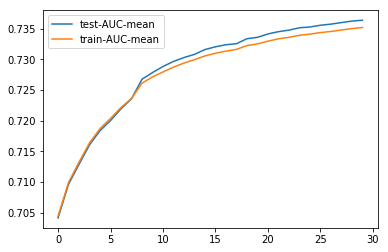

In [103]:
cv_data.plot(y=['test-AUC-mean', 'train-AUC-mean'])

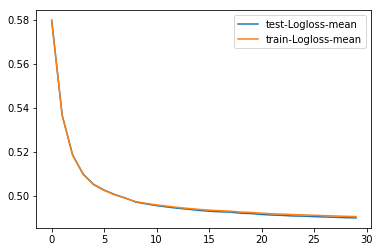

In [104]:
cv_data.plot(y=['test-Logloss-mean', 'train-Logloss-mean'])

### train with some randomly added na for contract variables
must be done before all feature engineering ? --> not necessarily (if variable identification is possible)

In [193]:
train.drop('target', axis=1, inplace=True)

In [194]:
var_with_new_categ_not_in_contract = [var for var in var_with_new_categ if var not in categ_contract]

In [195]:
quanti_contract = ['PRIX_FACTURE', 
                   'CONTRAT_TARIF',
                   'temps_depuis_debut_contrat',
                   'temps_jusqua_fin_contrat', 
                   'temps_depuis_maj_contrat']

In [196]:
variables = categ_contract + var_with_new_categ_not_in_contract
train = add_categories_in_columns(train, variables, ['NAN'])
test = add_categories_in_columns(test, variables, ['NAN'])

In [197]:
categoricals = train.select_dtypes(include=['category', 'bool', 'object']).columns
categorical_features_indices = [train.columns.get_loc(cat) for cat in categoricals]

In [198]:
models = []

params = {'iterations': 30,
          'border_count': 64,
          'learning_rate':0.30
}

for i in tqdm.tqdm_notebook(range(10)):
    _train = train.copy()
    
    _train = randomly_alter_modalities_on_same_line(_train, categ_contract, quanti_contract, 0.2)
    _train = randomly_alter_modalities(_train, var_with_new_categ_not_in_contract, 0.2)

    model = CatBoostClassifier(
        **params,
        verbose=False
    )
    
    model.fit(_train, y, cat_features=categorical_features_indices)
    models.append(model.copy())

In [199]:
predictions = []
for _model in tqdm.tqdm_notebook(models):
    predictions.append(_model.predict_proba(test)[:,1])
    
submission = np.vstack(predictions).T.mean(axis=1)
create_submission_file(submission, "catboost_rdmNA", params)

In [43]:
#prediction if multiple models
#prediction = np.hstack([predictions, predictions2]).mean(axis=1)

## LightGBM

In [11]:
import lightgbm

In [12]:
X_train_train, X_train_val, y_train_train, y_train_val = sklearn.model_selection.train_test_split(train, y, random_state=42, shuffle=True, stratify=y)

In [62]:
def learning_rate_010_decay_power_099(current_iter):
    base_learning_rate = 0.1
    lr = base_learning_rate  * np.power(.99, current_iter)
    return lr if lr > 1e-3 else 1e-3

def learning_rate_010_decay_power_0995(current_iter):
    base_learning_rate = 0.05
    lr = base_learning_rate  * np.power(.995, current_iter)
    return lr if lr > 1e-3 else 1e-3

def learning_rate_005_decay_power_099(current_iter):
    base_learning_rate = 0.05
    lr = base_learning_rate  * np.power(.99, current_iter)
    return lr if lr > 1e-3 else 1e-3

In [17]:
fit_params={"early_stopping_rounds":30, 
            "eval_metric" : 'auc', 
            "eval_set" : [(X_train_val, y_train_val)],
            'eval_names': ['valid'],
#            'callbacks': [lightgbm.reset_parameter(learning_rate=learning_rate_010_decay_power_0995)],
#            'callbacks': [lightgbm.reset_parameter(learning_rate=[0.01]*500 + [0.001]*500)],
            'verbose': 100,
            'categorical_feature': categorical_features_indices}

In [14]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
param_test ={'num_leaves': sp_randint(50, 500), 
             'min_data_in_leaf': sp_randint(50, 500), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100],
             'learning_rate' : [0.01]}

# 'cat_l2', 'max_cat_to_onehot'

In [20]:
#This parameter defines the number of HP points to be tested
n_HP_points_to_test = 10

import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

#n_estimators is set to a "large value". The actual number of trees build will depend on early stopping and 5000 define only the absolute maximum
clf = lgb.LGBMClassifier(max_depth=-1, random_state=314, silent=True, metric='None', n_jobs=4, n_estimators=5000)

gs = RandomizedSearchCV(
    estimator=clf, 
    param_distributions=param_test, 
    n_iter=n_HP_points_to_test,
    scoring='roc_auc',
    cv=3,
    refit=True,
    random_state=314,
    verbose=10)

In [21]:
gs.fit(X_train_train, y_train_train, **fit_params)
print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] colsample_bytree=0.9501241488957805, learning_rate=0.01, min_child_weight=0.1, min_data_in_leaf=392, num_leaves=92, reg_alpha=0, reg_lambda=100, subsample=0.9326466073236168 


/Users/WM1158/anaconda2/envs/dsc_hs/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 44, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 30 rounds.
[100]	valid's auc: 0.725566
[200]	valid's auc: 0.729107
[300]	valid's auc: 0.730321
[400]	valid's auc: 0.73097
Early stopping, best iteration is:
[449]	valid's auc: 0.731018
[CV]  colsample_bytree=0.9501241488957805, learning_rate=0.01, min_child_weight=0.1, min_data_in_leaf=392, num_leaves=92, reg_alpha=0, reg_lambda=100, subsample=0.9326466073236168, score=0.7286637027466945, total= 1.9min
[CV] colsample_bytree=0.9501241488957805, learning_rate=0.01, min_child_weight=0.1, min_data_in_leaf=392, num_leaves=92, reg_alpha=0, reg_lambda=100, subsample=0.9326466073236168 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.5min remaining:    0.0s
/Users/WM1158/anaconda2/envs/dsc_hs/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 44, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 30 rounds.
[100]	valid's auc: 0.725937
[200]	valid's auc: 0.729032
[300]	valid's auc: 0.730337
[400]	valid's auc: 0.730906
Early stopping, best iteration is:
[436]	valid's auc: 0.730963
[CV]  colsample_bytree=0.9501241488957805, learning_rate=0.01, min_child_weight=0.1, min_data_in_leaf=392, num_leaves=92, reg_alpha=0, reg_lambda=100, subsample=0.9326466073236168, score=0.7283079544940149, total= 1.9min
[CV] colsample_bytree=0.9501241488957805, learning_rate=0.01, min_child_weight=0.1, min_data_in_leaf=392, num_leaves=92, reg_alpha=0, reg_lambda=100, subsample=0.9326466073236168 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  4.8min remaining:    0.0s
/Users/WM1158/anaconda2/envs/dsc_hs/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 44, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 30 rounds.
[100]	valid's auc: 0.725956
[200]	valid's auc: 0.729156
[300]	valid's auc: 0.73006
[400]	valid's auc: 0.730685
Early stopping, best iteration is:
[436]	valid's auc: 0.730723
[CV]  colsample_bytree=0.9501241488957805, learning_rate=0.01, min_child_weight=0.1, min_data_in_leaf=392, num_leaves=92, reg_alpha=0, reg_lambda=100, subsample=0.9326466073236168, score=0.7281171773032348, total= 1.8min
[CV] colsample_bytree=0.9731668400523877, learning_rate=0.01, min_child_weight=1000.0, min_data_in_leaf=130, num_leaves=469, reg_alpha=10, reg_lambda=100, subsample=0.5575732396028996 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  7.0min remaining:    0.0s
/Users/WM1158/anaconda2/envs/dsc_hs/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 44, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 30 rounds.
[100]	valid's auc: 0.724089
[200]	valid's auc: 0.727725
[300]	valid's auc: 0.729792
[400]	valid's auc: 0.731617
[500]	valid's auc: 0.73243
[600]	valid's auc: 0.732756
[700]	valid's auc: 0.732829
Early stopping, best iteration is:
[736]	valid's auc: 0.732856
[CV]  colsample_bytree=0.9731668400523877, learning_rate=0.01, min_child_weight=1000.0, min_data_in_leaf=130, num_leaves=469, reg_alpha=10, reg_lambda=100, subsample=0.5575732396028996, score=0.7303327333691594, total= 2.4min
[CV] colsample_bytree=0.9731668400523877, learning_rate=0.01, min_child_weight=1000.0, min_data_in_leaf=130, num_leaves=469, reg_alpha=10, reg_lambda=100, subsample=0.5575732396028996 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  9.8min remaining:    0.0s
/Users/WM1158/anaconda2/envs/dsc_hs/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 44, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 30 rounds.
[100]	valid's auc: 0.724423
[200]	valid's auc: 0.727681
[300]	valid's auc: 0.729873
[400]	valid's auc: 0.731528
[500]	valid's auc: 0.732279
[600]	valid's auc: 0.732559
Early stopping, best iteration is:
[660]	valid's auc: 0.732651
[CV]  colsample_bytree=0.9731668400523877, learning_rate=0.01, min_child_weight=1000.0, min_data_in_leaf=130, num_leaves=469, reg_alpha=10, reg_lambda=100, subsample=0.5575732396028996, score=0.7299694006382137, total= 2.0min
[CV] colsample_bytree=0.9731668400523877, learning_rate=0.01, min_child_weight=1000.0, min_data_in_leaf=130, num_leaves=469, reg_alpha=10, reg_lambda=100, subsample=0.5575732396028996 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 12.2min remaining:    0.0s
/Users/WM1158/anaconda2/envs/dsc_hs/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 44, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 30 rounds.
[100]	valid's auc: 0.723862
[200]	valid's auc: 0.727496
[300]	valid's auc: 0.729585
[400]	valid's auc: 0.731373
[500]	valid's auc: 0.732079
[600]	valid's auc: 0.732375
[700]	valid's auc: 0.73254
Early stopping, best iteration is:
[763]	valid's auc: 0.732576
[CV]  colsample_bytree=0.9731668400523877, learning_rate=0.01, min_child_weight=1000.0, min_data_in_leaf=130, num_leaves=469, reg_alpha=10, reg_lambda=100, subsample=0.5575732396028996, score=0.7296141018783997, total= 2.4min
[CV] colsample_bytree=0.7756038066515227, learning_rate=0.01, min_child_weight=1, min_data_in_leaf=223, num_leaves=154, reg_alpha=100, reg_lambda=0, subsample=0.8720649952803985 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 15.0min remaining:    0.0s
/Users/WM1158/anaconda2/envs/dsc_hs/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 44, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 30 rounds.
[100]	valid's auc: 0.725623
[200]	valid's auc: 0.729204
[300]	valid's auc: 0.731429
[400]	valid's auc: 0.732564
[500]	valid's auc: 0.732965
[600]	valid's auc: 0.733082
Early stopping, best iteration is:
[633]	valid's auc: 0.733146
[CV]  colsample_bytree=0.7756038066515227, learning_rate=0.01, min_child_weight=1, min_data_in_leaf=223, num_leaves=154, reg_alpha=100, reg_lambda=0, subsample=0.8720649952803985, score=0.7306635418949364, total= 2.8min
[CV] colsample_bytree=0.7756038066515227, learning_rate=0.01, min_child_weight=1, min_data_in_leaf=223, num_leaves=154, reg_alpha=100, reg_lambda=0, subsample=0.8720649952803985 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 18.6min remaining:    0.0s
/Users/WM1158/anaconda2/envs/dsc_hs/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 44, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 30 rounds.
[100]	valid's auc: 0.72594
[200]	valid's auc: 0.729238
[300]	valid's auc: 0.731497
[400]	valid's auc: 0.732676
[500]	valid's auc: 0.733214
Early stopping, best iteration is:
[556]	valid's auc: 0.733321
[CV]  colsample_bytree=0.7756038066515227, learning_rate=0.01, min_child_weight=1, min_data_in_leaf=223, num_leaves=154, reg_alpha=100, reg_lambda=0, subsample=0.8720649952803985, score=0.7307666422449306, total= 2.3min
[CV] colsample_bytree=0.7756038066515227, learning_rate=0.01, min_child_weight=1, min_data_in_leaf=223, num_leaves=154, reg_alpha=100, reg_lambda=0, subsample=0.8720649952803985 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 21.6min remaining:    0.0s
/Users/WM1158/anaconda2/envs/dsc_hs/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 44, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 30 rounds.
[100]	valid's auc: 0.725488
[200]	valid's auc: 0.729088
[300]	valid's auc: 0.731221
[400]	valid's auc: 0.732392
[500]	valid's auc: 0.732883
[600]	valid's auc: 0.732972
Early stopping, best iteration is:
[585]	valid's auc: 0.732984
[CV]  colsample_bytree=0.7756038066515227, learning_rate=0.01, min_child_weight=1, min_data_in_leaf=223, num_leaves=154, reg_alpha=100, reg_lambda=0, subsample=0.8720649952803985, score=0.7304872286562645, total= 2.6min
[CV] colsample_bytree=0.566907616105705, learning_rate=0.01, min_child_weight=0.01, min_data_in_leaf=377, num_leaves=392, reg_alpha=2, reg_lambda=5, subsample=0.6649855489918759 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 24.9min remaining:    0.0s
/Users/WM1158/anaconda2/envs/dsc_hs/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 44, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 30 rounds.
[100]	valid's auc: 0.726011
[200]	valid's auc: 0.727591
Early stopping, best iteration is:
[220]	valid's auc: 0.727863
[CV]  colsample_bytree=0.566907616105705, learning_rate=0.01, min_child_weight=0.01, min_data_in_leaf=377, num_leaves=392, reg_alpha=2, reg_lambda=5, subsample=0.6649855489918759, score=0.7255311938408704, total= 1.4min
[CV] colsample_bytree=0.566907616105705, learning_rate=0.01, min_child_weight=0.01, min_data_in_leaf=377, num_leaves=392, reg_alpha=2, reg_lambda=5, subsample=0.6649855489918759 


/Users/WM1158/anaconda2/envs/dsc_hs/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 44, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 30 rounds.
[100]	valid's auc: 0.726664
[200]	valid's auc: 0.728284
Early stopping, best iteration is:
[256]	valid's auc: 0.728609
[CV]  colsample_bytree=0.566907616105705, learning_rate=0.01, min_child_weight=0.01, min_data_in_leaf=377, num_leaves=392, reg_alpha=2, reg_lambda=5, subsample=0.6649855489918759, score=0.7251097484996816, total= 1.7min
[CV] colsample_bytree=0.566907616105705, learning_rate=0.01, min_child_weight=0.01, min_data_in_leaf=377, num_leaves=392, reg_alpha=2, reg_lambda=5, subsample=0.6649855489918759 


/Users/WM1158/anaconda2/envs/dsc_hs/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 44, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 30 rounds.
[100]	valid's auc: 0.725587
[200]	valid's auc: 0.727461
Early stopping, best iteration is:
[248]	valid's auc: 0.727761
[CV]  colsample_bytree=0.566907616105705, learning_rate=0.01, min_child_weight=0.01, min_data_in_leaf=377, num_leaves=392, reg_alpha=2, reg_lambda=5, subsample=0.6649855489918759, score=0.7250524823515283, total= 1.6min
[CV] colsample_bytree=0.8063232376017694, learning_rate=0.01, min_child_weight=1000.0, min_data_in_leaf=277, num_leaves=388, reg_alpha=100, reg_lambda=20, subsample=0.6564417745729645 


/Users/WM1158/anaconda2/envs/dsc_hs/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 44, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 30 rounds.
[100]	valid's auc: 0.723038
[200]	valid's auc: 0.726607
[300]	valid's auc: 0.728863
[400]	valid's auc: 0.730622
[500]	valid's auc: 0.731807
[600]	valid's auc: 0.732505
[700]	valid's auc: 0.732902
[800]	valid's auc: 0.733199
[900]	valid's auc: 0.733392
[1000]	valid's auc: 0.733542
[1100]	valid's auc: 0.733638
[1200]	valid's auc: 0.733691
[1300]	valid's auc: 0.733717
Early stopping, best iteration is:
[1315]	valid's auc: 0.733729
[CV]  colsample_bytree=0.8063232376017694, learning_rate=0.01, min_child_weight=1000.0, min_data_in_leaf=277, num_leaves=388, reg_alpha=100, reg_lambda=20, subsample=0.6564417745729645, score=0.7313502776494698, total= 2.9min
[CV] colsample_bytree=0.8063232376017694, learning_rate=0.01, min_child_weight=1000.0, min_data_in_leaf=277, num_leaves=388, reg_alpha=100, reg_lambda=20, subsample=0.6564417745729645 


/Users/WM1158/anaconda2/envs/dsc_hs/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 44, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 30 rounds.
[100]	valid's auc: 0.723093
[200]	valid's auc: 0.72646
[300]	valid's auc: 0.728807
[400]	valid's auc: 0.730584
[500]	valid's auc: 0.73185
[600]	valid's auc: 0.732489
[700]	valid's auc: 0.732866
[800]	valid's auc: 0.733105
[900]	valid's auc: 0.733296
[1000]	valid's auc: 0.733398
[1100]	valid's auc: 0.733504
[1200]	valid's auc: 0.733579
Early stopping, best iteration is:
[1245]	valid's auc: 0.733598
[CV]  colsample_bytree=0.8063232376017694, learning_rate=0.01, min_child_weight=1000.0, min_data_in_leaf=277, num_leaves=388, reg_alpha=100, reg_lambda=20, subsample=0.6564417745729645, score=0.7310578363231441, total= 2.6min
[CV] colsample_bytree=0.8063232376017694, learning_rate=0.01, min_child_weight=1000.0, min_data_in_leaf=277, num_leaves=388, reg_alpha=100, reg_lambda=20, subsample=0.6564417745729645 


/Users/WM1158/anaconda2/envs/dsc_hs/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 44, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 30 rounds.
[100]	valid's auc: 0.722741
[200]	valid's auc: 0.726435
[300]	valid's auc: 0.72856
[400]	valid's auc: 0.730461
[500]	valid's auc: 0.731678
[600]	valid's auc: 0.732329
[700]	valid's auc: 0.732745
[800]	valid's auc: 0.733006
[900]	valid's auc: 0.733173
[1000]	valid's auc: 0.733306
[1100]	valid's auc: 0.733378
[1200]	valid's auc: 0.733428
Early stopping, best iteration is:
[1257]	valid's auc: 0.733451
[CV]  colsample_bytree=0.8063232376017694, learning_rate=0.01, min_child_weight=1000.0, min_data_in_leaf=277, num_leaves=388, reg_alpha=100, reg_lambda=20, subsample=0.6564417745729645, score=0.7306444899566948, total= 2.7min
[CV] colsample_bytree=0.6879091728281055, learning_rate=0.01, min_child_weight=10.0, min_data_in_leaf=438, num_leaves=228, reg_alpha=10, reg_lambda=5, subsample=0.5065412058017 


/Users/WM1158/anaconda2/envs/dsc_hs/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 44, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 30 rounds.
[100]	valid's auc: 0.72633
[200]	valid's auc: 0.728396
Early stopping, best iteration is:
[256]	valid's auc: 0.728586
[CV]  colsample_bytree=0.6879091728281055, learning_rate=0.01, min_child_weight=10.0, min_data_in_leaf=438, num_leaves=228, reg_alpha=10, reg_lambda=5, subsample=0.5065412058017, score=0.7262845001268944, total= 1.6min
[CV] colsample_bytree=0.6879091728281055, learning_rate=0.01, min_child_weight=10.0, min_data_in_leaf=438, num_leaves=228, reg_alpha=10, reg_lambda=5, subsample=0.5065412058017 


/Users/WM1158/anaconda2/envs/dsc_hs/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 44, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 30 rounds.
[100]	valid's auc: 0.726841
[200]	valid's auc: 0.728833
Early stopping, best iteration is:
[248]	valid's auc: 0.729077
[CV]  colsample_bytree=0.6879091728281055, learning_rate=0.01, min_child_weight=10.0, min_data_in_leaf=438, num_leaves=228, reg_alpha=10, reg_lambda=5, subsample=0.5065412058017, score=0.725765783501029, total= 1.5min
[CV] colsample_bytree=0.6879091728281055, learning_rate=0.01, min_child_weight=10.0, min_data_in_leaf=438, num_leaves=228, reg_alpha=10, reg_lambda=5, subsample=0.5065412058017 


/Users/WM1158/anaconda2/envs/dsc_hs/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 44, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 30 rounds.
[100]	valid's auc: 0.72611
[200]	valid's auc: 0.728146
Early stopping, best iteration is:
[234]	valid's auc: 0.72839
[CV]  colsample_bytree=0.6879091728281055, learning_rate=0.01, min_child_weight=10.0, min_data_in_leaf=438, num_leaves=228, reg_alpha=10, reg_lambda=5, subsample=0.5065412058017, score=0.7258665020465196, total= 1.4min
[CV] colsample_bytree=0.7442526692235505, learning_rate=0.01, min_child_weight=0.01, min_data_in_leaf=434, num_leaves=258, reg_alpha=0.1, reg_lambda=50, subsample=0.5673489081424845 


/Users/WM1158/anaconda2/envs/dsc_hs/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 44, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 30 rounds.
[100]	valid's auc: 0.72541
[200]	valid's auc: 0.727879
[300]	valid's auc: 0.728287
Early stopping, best iteration is:
[291]	valid's auc: 0.7283
[CV]  colsample_bytree=0.7442526692235505, learning_rate=0.01, min_child_weight=0.01, min_data_in_leaf=434, num_leaves=258, reg_alpha=0.1, reg_lambda=50, subsample=0.5673489081424845, score=0.7258789855318358, total= 1.8min
[CV] colsample_bytree=0.7442526692235505, learning_rate=0.01, min_child_weight=0.01, min_data_in_leaf=434, num_leaves=258, reg_alpha=0.1, reg_lambda=50, subsample=0.5673489081424845 


/Users/WM1158/anaconda2/envs/dsc_hs/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 44, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 30 rounds.
[100]	valid's auc: 0.726237
[200]	valid's auc: 0.72838
Early stopping, best iteration is:
[261]	valid's auc: 0.728755
[CV]  colsample_bytree=0.7442526692235505, learning_rate=0.01, min_child_weight=0.01, min_data_in_leaf=434, num_leaves=258, reg_alpha=0.1, reg_lambda=50, subsample=0.5673489081424845, score=0.7254046004162854, total= 1.8min
[CV] colsample_bytree=0.7442526692235505, learning_rate=0.01, min_child_weight=0.01, min_data_in_leaf=434, num_leaves=258, reg_alpha=0.1, reg_lambda=50, subsample=0.5673489081424845 


/Users/WM1158/anaconda2/envs/dsc_hs/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 44, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 30 rounds.
[100]	valid's auc: 0.725532
[200]	valid's auc: 0.727621
Early stopping, best iteration is:
[248]	valid's auc: 0.727962
[CV]  colsample_bytree=0.7442526692235505, learning_rate=0.01, min_child_weight=0.01, min_data_in_leaf=434, num_leaves=258, reg_alpha=0.1, reg_lambda=50, subsample=0.5673489081424845, score=0.7255012191865173, total= 1.9min
[CV] colsample_bytree=0.46175306323300236, learning_rate=0.01, min_child_weight=0.01, min_data_in_leaf=493, num_leaves=239, reg_alpha=0, reg_lambda=1, subsample=0.7749764742347831 


/Users/WM1158/anaconda2/envs/dsc_hs/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 44, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 30 rounds.
[100]	valid's auc: 0.726756
[200]	valid's auc: 0.728733
[300]	valid's auc: 0.729186
[400]	valid's auc: 0.729293
Early stopping, best iteration is:
[370]	valid's auc: 0.729371
[CV]  colsample_bytree=0.46175306323300236, learning_rate=0.01, min_child_weight=0.01, min_data_in_leaf=493, num_leaves=239, reg_alpha=0, reg_lambda=1, subsample=0.7749764742347831, score=0.7271353235756597, total= 1.9min
[CV] colsample_bytree=0.46175306323300236, learning_rate=0.01, min_child_weight=0.01, min_data_in_leaf=493, num_leaves=239, reg_alpha=0, reg_lambda=1, subsample=0.7749764742347831 


/Users/WM1158/anaconda2/envs/dsc_hs/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 44, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 30 rounds.
[100]	valid's auc: 0.727247
[200]	valid's auc: 0.729057
[300]	valid's auc: 0.729762
[400]	valid's auc: 0.729837
Early stopping, best iteration is:
[377]	valid's auc: 0.729871
[CV]  colsample_bytree=0.46175306323300236, learning_rate=0.01, min_child_weight=0.01, min_data_in_leaf=493, num_leaves=239, reg_alpha=0, reg_lambda=1, subsample=0.7749764742347831, score=0.726759851363141, total= 2.1min
[CV] colsample_bytree=0.46175306323300236, learning_rate=0.01, min_child_weight=0.01, min_data_in_leaf=493, num_leaves=239, reg_alpha=0, reg_lambda=1, subsample=0.7749764742347831 


/Users/WM1158/anaconda2/envs/dsc_hs/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 44, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 30 rounds.
[100]	valid's auc: 0.726296
[200]	valid's auc: 0.728349
[300]	valid's auc: 0.728856
Early stopping, best iteration is:
[365]	valid's auc: 0.728988
[CV]  colsample_bytree=0.46175306323300236, learning_rate=0.01, min_child_weight=0.01, min_data_in_leaf=493, num_leaves=239, reg_alpha=0, reg_lambda=1, subsample=0.7749764742347831, score=0.7262872249684087, total= 2.0min
[CV] colsample_bytree=0.9870576100176972, learning_rate=0.01, min_child_weight=1e-05, min_data_in_leaf=406, num_leaves=141, reg_alpha=50, reg_lambda=20, subsample=0.31177597327519274 


/Users/WM1158/anaconda2/envs/dsc_hs/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 44, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 30 rounds.
[100]	valid's auc: 0.725301
[200]	valid's auc: 0.729259
[300]	valid's auc: 0.730873
[400]	valid's auc: 0.731482
Early stopping, best iteration is:
[417]	valid's auc: 0.731523
[CV]  colsample_bytree=0.9870576100176972, learning_rate=0.01, min_child_weight=1e-05, min_data_in_leaf=406, num_leaves=141, reg_alpha=50, reg_lambda=20, subsample=0.31177597327519274, score=0.7290275047315236, total= 2.1min
[CV] colsample_bytree=0.9870576100176972, learning_rate=0.01, min_child_weight=1e-05, min_data_in_leaf=406, num_leaves=141, reg_alpha=50, reg_lambda=20, subsample=0.31177597327519274 


/Users/WM1158/anaconda2/envs/dsc_hs/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 44, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 30 rounds.
[100]	valid's auc: 0.725948
[200]	valid's auc: 0.729117
[300]	valid's auc: 0.730676
[400]	valid's auc: 0.731418
Early stopping, best iteration is:
[452]	valid's auc: 0.731532
[CV]  colsample_bytree=0.9870576100176972, learning_rate=0.01, min_child_weight=1e-05, min_data_in_leaf=406, num_leaves=141, reg_alpha=50, reg_lambda=20, subsample=0.31177597327519274, score=0.7288087174188136, total= 2.3min
[CV] colsample_bytree=0.9870576100176972, learning_rate=0.01, min_child_weight=1e-05, min_data_in_leaf=406, num_leaves=141, reg_alpha=50, reg_lambda=20, subsample=0.31177597327519274 


/Users/WM1158/anaconda2/envs/dsc_hs/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 44, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 30 rounds.
[100]	valid's auc: 0.72576
[200]	valid's auc: 0.729276
[300]	valid's auc: 0.730708
[400]	valid's auc: 0.731381
Early stopping, best iteration is:
[446]	valid's auc: 0.731458
[CV]  colsample_bytree=0.9870576100176972, learning_rate=0.01, min_child_weight=1e-05, min_data_in_leaf=406, num_leaves=141, reg_alpha=50, reg_lambda=20, subsample=0.31177597327519274, score=0.7288234459125204, total= 2.3min
[CV] colsample_bytree=0.45023302669289644, learning_rate=0.01, min_child_weight=1e-05, min_data_in_leaf=373, num_leaves=92, reg_alpha=0, reg_lambda=50, subsample=0.3191480164925895 


/Users/WM1158/anaconda2/envs/dsc_hs/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 44, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 30 rounds.
[100]	valid's auc: 0.726551
[200]	valid's auc: 0.729745
[300]	valid's auc: 0.731095
[400]	valid's auc: 0.731905
[500]	valid's auc: 0.732085
Early stopping, best iteration is:
[483]	valid's auc: 0.732122
[CV]  colsample_bytree=0.45023302669289644, learning_rate=0.01, min_child_weight=1e-05, min_data_in_leaf=373, num_leaves=92, reg_alpha=0, reg_lambda=50, subsample=0.3191480164925895, score=0.7297744184269135, total= 1.5min
[CV] colsample_bytree=0.45023302669289644, learning_rate=0.01, min_child_weight=1e-05, min_data_in_leaf=373, num_leaves=92, reg_alpha=0, reg_lambda=50, subsample=0.3191480164925895 


/Users/WM1158/anaconda2/envs/dsc_hs/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 44, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 30 rounds.
[100]	valid's auc: 0.726777
[200]	valid's auc: 0.72971
[300]	valid's auc: 0.731181
[400]	valid's auc: 0.731893
[500]	valid's auc: 0.732078
Early stopping, best iteration is:
[483]	valid's auc: 0.732129
[CV]  colsample_bytree=0.45023302669289644, learning_rate=0.01, min_child_weight=1e-05, min_data_in_leaf=373, num_leaves=92, reg_alpha=0, reg_lambda=50, subsample=0.3191480164925895, score=0.729455634766314, total= 1.4min
[CV] colsample_bytree=0.45023302669289644, learning_rate=0.01, min_child_weight=1e-05, min_data_in_leaf=373, num_leaves=92, reg_alpha=0, reg_lambda=50, subsample=0.3191480164925895 


/Users/WM1158/anaconda2/envs/dsc_hs/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 44, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 30 rounds.
[100]	valid's auc: 0.72636
[200]	valid's auc: 0.729395
[300]	valid's auc: 0.730806
[400]	valid's auc: 0.73155
Early stopping, best iteration is:
[458]	valid's auc: 0.731709
[CV]  colsample_bytree=0.45023302669289644, learning_rate=0.01, min_child_weight=1e-05, min_data_in_leaf=373, num_leaves=92, reg_alpha=0, reg_lambda=50, subsample=0.3191480164925895, score=0.7290573947085652, total= 1.3min


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 75.9min finished
/Users/WM1158/anaconda2/envs/dsc_hs/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 44, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 30 rounds.
[100]	valid's auc: 0.724846
[200]	valid's auc: 0.728537
[300]	valid's auc: 0.731036
[400]	valid's auc: 0.732775
[500]	valid's auc: 0.734098
[600]	valid's auc: 0.734797
[700]	valid's auc: 0.735229
[800]	valid's auc: 0.735494
[900]	valid's auc: 0.735669
[1000]	valid's auc: 0.735778
[1100]	valid's auc: 0.735862
[1200]	valid's auc: 0.735942
[1300]	valid's auc: 0.735995
Early stopping, best iteration is:
[1285]	valid's auc: 0.736003
Best score reached: 0.7310175350664282 with params: {'colsample_bytree': 0.8063232376017694, 'learning_rate': 0.01, 'min_child_weight': 1000.0, 'min_data_in_leaf': 277, 'num_leaves': 388, 'reg_alpha': 100, 'reg_lambda': 20, 'subsample': 0.6564417745729645} 


In [38]:
gs.cv_results_

/Users/WM1158/anaconda2/envs/dsc_hs/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/WM1158/anaconda2/envs/dsc_hs/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/WM1158/anaconda2/envs/dsc_hs/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_

{'mean_fit_time': array([101.40153567, 122.36728565, 125.87989823,  82.2564702 ,
        143.13933539,  76.45728501,  94.99013996,  99.48873472,
        117.74867002,  71.9784468 ]),
 'std_fit_time': array([ 3.11539729, 10.7419779 ,  7.93682453,  5.80741981,  4.00824345,
         3.01826232,  2.34458758,  4.06866339,  3.54841394,  2.19106088]),
 'mean_score_time': array([11.90414604, 11.57656447, 26.5632604 , 13.8254234 , 21.69088006,
        11.45818726, 13.06167761, 18.92411963, 17.74678731, 13.4035577 ]),
 'std_score_time': array([1.11722103, 0.54884254, 3.78958372, 2.00309469, 3.78529372,
        2.67494313, 1.08908811, 0.92413033, 1.74856265, 1.54942533]),
 'param_colsample_bytree': masked_array(data=[0.9501241488957805, 0.9731668400523877,
                    0.7756038066515227, 0.566907616105705,
                    0.8063232376017694, 0.6879091728281055,
                    0.7442526692235505, 0.46175306323300236,
                    0.9870576100176972, 0.45023302669289644],
  

In [36]:
#second best (550 iterations)
gs.cv_results_['params'][2]

{'colsample_bytree': 0.7756038066515227,
 'learning_rate': 0.01,
 'min_child_weight': 1,
 'min_data_in_leaf': 223,
 'num_leaves': 154,
 'reg_alpha': 100,
 'reg_lambda': 0,
 'subsample': 0.8720649952803985}

{'colsample_bytree': 0.7756038066515227,
 'learning_rate': 0.01,
 'min_child_weight': 1,
 'min_data_in_leaf': 223,
 'num_leaves': 154,
 'reg_alpha': 100,
 'reg_lambda': 0,
 'subsample': 0.8720649952803985,
 'n_estimators': 550}


{'colsample_bytree': 0.8063232376017694, 
          'learning_rate': 0.01, 
          'min_child_weight': 1000.0, 
          'min_data_in_leaf': 277, 
          'num_leaves': 388, 
          'reg_alpha': 100, 
          'reg_lambda': 20, 
          'subsample': 0.6564417745729645,
          'n_estimators': 1200} 


In [42]:
params = {'colsample_bytree': 0.7756038066515227,
 'learning_rate': 0.01,
 'min_child_weight': 1,
 'min_data_in_leaf': 223,
 'num_leaves': 154,
 'reg_alpha': 100,
 'reg_lambda': 0,
 'subsample': 0.8720649952803985,
 'n_estimators': 550}

model_gbm = lightgbm.LGBMClassifier(
    **params,
    seed=np.random.randint(10**10),
    is_unbalance=True,
    objective='binary'
)

model_gbm.fit(train, y, categorical_feature=categorical_features_indices)

/Users/WM1158/anaconda2/envs/dsc_hs/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 44, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


LGBMClassifier(boosting_type='gbdt', class_weight=None,
        colsample_bytree=0.7756038066515227, is_unbalance=True,
        learning_rate=0.01, max_depth=-1, min_child_samples=20,
        min_child_weight=1, min_data_in_leaf=223, min_split_gain=0.0,
        n_estimators=550, n_jobs=-1, num_leaves=154, objective='binary',
        random_state=None, reg_alpha=100, reg_lambda=0, seed=7908093457,
        silent=True, subsample=0.8720649952803985,
        subsample_for_bin=200000, subsample_freq=0)

In [43]:
submission = model_gbm.predict_proba(test)[:, 1]
create_submission_file(submission, "lightgbm_", params)

## LR

0.71

In [119]:
from sklearn.preprocessing import OneHotEncoder
#from scipy.sparse import csr_matrix,csc_matrix
from sklearn.cross_validation import StratifiedKFold
#from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier, LogisticRegressionCV
from sklearn.metrics import roc_auc_score
#from sklearn.preprocessing import LabelEncoder

In [112]:
categoricals = train.select_dtypes(include=['category']).columns
categorical_features_indices = [train.columns.get_loc(cat) for cat in categoricals]

In [113]:
for item in train.select_dtypes(include=['category']).columns:
    train[item] = train[item].cat.codes
    test[item] = test[item].cat.codes

In [117]:
kfolder = StratifiedKFold(y, n_folds=5, shuffle=True, random_state=1)
grand_auc = 0

X = np.array(train)
i=0 # iterator counter
#model = SGDClassifier(loss='log', penalty='l2', alpha=0.0030, max_iter=30, random_state=1)
#model = SGDClassifier(loss="hinge", alpha=0.01, max_iter=30)

for train_index, test_index in kfolder:
        X_train, X_cv = np.array(X)[train_index], np.array(X)[test_index]
        y_train, y_cv = np.array(y)[train_index], np.array(y)[test_index]
        one=OneHotEncoder(handle_unknown='ignore', categorical_features=categorical_features_indices)
        one.fit(X_train)
        X_train=one.transform(X_train)
        X_cv=one.transform(X_cv)
        model.fit(X_train,y_train)
        preds=model.predict_proba(X_cv)[:,1]
        auc=roc_auc_score(y_cv,preds)
        print (" fold %d/%d auc %f " % (i+1, 5, auc))
        grand_auc+=auc
        i+=1
grand_auc/=5
print ("grand AUC is %f " % (grand_auc))

AttributeError: probability estimates are not available for loss='hinge'

In [122]:
model = LogisticRegressionCV(scoring='roc_auc')
#one=OneHotEncoder(handle_unknown='ignore', categorical_features=categorical_features_indices)
#one.fit(X)
#X=one.transform(X)
#X_cv=one.transform(X_cv)
model.fit(X, y)
#preds=model.predict_proba(X_cv)[:,1]
#auc=roc_auc_score(y_cv,preds)
#print (" fold %d/%d auc %f " % (i+1, 5, auc))


LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring='roc_auc', solver='lbfgs', tol=0.0001,
           verbose=0)

In [125]:
model.C_

array([0.00599484])

In [127]:
one=OneHotEncoder(handle_unknown='ignore', categorical_features=categorical_features_indices)
one.fit(train)
test_ohe=one.transform(test)
submission = model.predict_proba(test_ohe)[:,1]

array([0.39875361, 0.16195149, 0.08336156, ..., 0.21348615, 0.08730254,
       0.24835877])

In [128]:
submission = model.predict_proba(test_ohe)[:,1]

In [129]:
create_submission_file(submission, "LR_l2_", {'C': 0.00599484})

# Stacking

In [10]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import LinearSVC, SVC

In [11]:
ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 0 # for reproducibility
NFOLDS = 5 # set folds for out-of-fold prediction

In [12]:
# Kfold
kf = StratifiedKFold(n_splits=NFOLDS, random_state=SEED, shuffle=True)
#kf_splits = kf.split(train, y)

In [13]:
pos_neg_ratio =  sum(y==False) / sum(y==True)

In [28]:
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train, cats=None, model=None):
        if (cats is not None) & (model=='catboost'):
            self.clf.fit(x_train, y_train, cat_features=cats)
        elif (cats is not None) & (model=='lightgbm'):
            self.clf.fit(x_train, y_train, categorical_feature=cats)
        else:
            self.clf.fit(x_train, y_train)

    def predict(self, x, model=None):
        if model == 'svm':
            return self.clf.predict(x)
        else:
            return self.clf.predict_proba(x)[:,1]
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)


In [24]:
def get_oof(clf, x_train, y_train, x_test, cats=None, model=None):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))


    for i, (train_index, test_index) in enumerate(kf.split(x_train, y_train)):
        print('Fold ', i+1, '/', NFOLDS)
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        
        #randomly_alter_modalities_on_same_line(_train, categ_contract, quanti_contract, 0.2)
        #
        #
        clf.train(x_tr, y_tr, cats, model)

        oof_train[test_index] = clf.predict(x_te, model)
        oof_test_skf[i, :] = clf.predict(x_test, model)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [16]:
catboost_1_params = {
                      'border_count': 64, 
                      'iterations': 500.0,
                      'learning_rate': 0.05,
                      'l2_leaf_reg': 10,
                      'scale_pos_weight': pos_neg_ratio,
                      'eval_metric': "AUC"
                     }


lightgbm_1_params = {'colsample_bytree': 0.7756038066515227,
                     'learning_rate': 0.01,
                     'min_child_weight': 1,
                     'min_data_in_leaf': 223,
                     'num_leaves': 154,
                     'reg_alpha': 100,
                     'reg_lambda': 0,
                     'subsample': 0.8720649952803985,
                     'n_estimators': 550,
                     'scoring': 'roc_auc'}

lightgbm_2_params = {'colsample_bytree': 0.8063232376017694, 
                      'learning_rate': 0.01, 
                      'min_child_weight': 1000.0, 
                      'min_data_in_leaf': 277, 
                      'num_leaves': 388, 
                      'reg_alpha': 100, 
                      'reg_lambda': 20, 
                      'subsample': 0.6564417745729645,
                      'n_estimators': 1200,
                      'scoring': 'roc_auc'}  

SVC_params = {'alpha': 0.0001, 'max_iter': 1000, 'tol': 0.01}

LR_params = {'C': 0.00599484}

In [17]:
# Create 5 objects that represent our 4 models
catboost_1 = SklearnHelper(clf=CatBoostClassifier, seed=SEED, params=catboost_1_params)
lightgbm_1 = SklearnHelper(clf=LGBMClassifier, seed=SEED, params=lightgbm_1_params)
lightgbm_2 = SklearnHelper(clf=LGBMClassifier, seed=SEED, params=lightgbm_2_params)
svc = SklearnHelper(clf=SGDClassifier, seed=SEED, params=SVC_params)
LR = SklearnHelper(clf=LogisticRegression, seed=SEED, params=LR_params)

In [18]:
for item in train.select_dtypes(include=['category']).columns:
    train[item] = train[item].cat.codes
    test[item] = test[item].cat.codes

x_train = train.values
y_train = y.values
x_test = test.values

del train, y, test

In [19]:
# Create our OOF train and test predictions. These base results will be used as new features
print("Training catboost1")
catboost_1_oof_train, catboost_1_oof_test = get_oof(catboost_1, x_train, y_train, x_test, cats=categorical_features_indices, model='catboost') 
np.savetxt("catboost_1_oof_train.csv", catboost_1_oof_train, delimiter=",")
np.savetxt("catboost_1_oof_test.csv", catboost_1_oof_test, delimiter=",")

Training catboost1
Fold  0 / 5
0:	total: 6.45s	remaining: 53m 40s
1:	total: 11.9s	remaining: 49m 35s
2:	total: 16.9s	remaining: 46m 44s
3:	total: 21.8s	remaining: 45m 6s
4:	total: 27s	remaining: 44m 34s
5:	total: 31.7s	remaining: 43m 31s
6:	total: 36.5s	remaining: 42m 49s
7:	total: 41s	remaining: 42m 3s
8:	total: 46s	remaining: 41m 50s
9:	total: 50.7s	remaining: 41m 24s
10:	total: 55.4s	remaining: 41m 3s
11:	total: 1m	remaining: 40m 52s
12:	total: 1m 5s	remaining: 41m 5s
13:	total: 1m 10s	remaining: 40m 54s
14:	total: 1m 15s	remaining: 40m 49s
15:	total: 1m 20s	remaining: 40m 36s
16:	total: 1m 25s	remaining: 40m 36s
17:	total: 1m 31s	remaining: 40m 40s
18:	total: 1m 36s	remaining: 40m 38s
19:	total: 1m 41s	remaining: 40m 32s
20:	total: 1m 46s	remaining: 40m 26s
21:	total: 1m 51s	remaining: 40m 16s
22:	total: 1m 56s	remaining: 40m 14s
23:	total: 2m 1s	remaining: 40m 16s
24:	total: 2m 7s	remaining: 40m 30s
25:	total: 2m 13s	remaining: 40m 33s
26:	total: 2m 18s	remaining: 40m 33s
27:	tota

218:	total: 19m 20s	remaining: 24m 49s
219:	total: 19m 25s	remaining: 24m 43s
220:	total: 19m 29s	remaining: 24m 36s
221:	total: 19m 35s	remaining: 24m 32s
222:	total: 19m 41s	remaining: 24m 27s
223:	total: 19m 45s	remaining: 24m 21s
224:	total: 19m 51s	remaining: 24m 16s
225:	total: 19m 57s	remaining: 24m 11s
226:	total: 20m 4s	remaining: 24m 8s
227:	total: 20m 8s	remaining: 24m 2s
228:	total: 20m 14s	remaining: 23m 57s
229:	total: 20m 20s	remaining: 23m 52s
230:	total: 20m 25s	remaining: 23m 47s
231:	total: 20m 30s	remaining: 23m 41s
232:	total: 20m 36s	remaining: 23m 37s
233:	total: 20m 43s	remaining: 23m 33s
234:	total: 20m 49s	remaining: 23m 28s
235:	total: 20m 54s	remaining: 23m 22s
236:	total: 20m 59s	remaining: 23m 18s
237:	total: 21m 5s	remaining: 23m 12s
238:	total: 21m 9s	remaining: 23m 6s
239:	total: 21m 15s	remaining: 23m 1s
240:	total: 21m 20s	remaining: 22m 55s
241:	total: 21m 25s	remaining: 22m 50s
242:	total: 21m 30s	remaining: 22m 45s
243:	total: 21m 35s	remaining: 22

432:	total: 38m 36s	remaining: 5m 58s
433:	total: 38m 42s	remaining: 5m 53s
434:	total: 38m 47s	remaining: 5m 47s
435:	total: 38m 52s	remaining: 5m 42s
436:	total: 38m 57s	remaining: 5m 36s
437:	total: 39m 2s	remaining: 5m 31s
438:	total: 39m 8s	remaining: 5m 26s
439:	total: 39m 13s	remaining: 5m 20s
440:	total: 39m 19s	remaining: 5m 15s
441:	total: 39m 25s	remaining: 5m 10s
442:	total: 39m 30s	remaining: 5m 5s
443:	total: 39m 36s	remaining: 4m 59s
444:	total: 39m 41s	remaining: 4m 54s
445:	total: 39m 46s	remaining: 4m 48s
446:	total: 39m 52s	remaining: 4m 43s
447:	total: 39m 57s	remaining: 4m 38s
448:	total: 40m 3s	remaining: 4m 33s
449:	total: 40m 9s	remaining: 4m 27s
450:	total: 40m 14s	remaining: 4m 22s
451:	total: 40m 19s	remaining: 4m 16s
452:	total: 40m 25s	remaining: 4m 11s
453:	total: 40m 31s	remaining: 4m 6s
454:	total: 40m 37s	remaining: 4m 1s
455:	total: 40m 43s	remaining: 3m 55s
456:	total: 40m 47s	remaining: 3m 50s
457:	total: 40m 53s	remaining: 3m 44s
458:	total: 40m 58s

153:	total: 13m 24s	remaining: 30m 8s
154:	total: 13m 29s	remaining: 30m 2s
155:	total: 13m 34s	remaining: 29m 55s
156:	total: 13m 39s	remaining: 29m 50s
157:	total: 13m 44s	remaining: 29m 44s
158:	total: 13m 49s	remaining: 29m 38s
159:	total: 13m 55s	remaining: 29m 34s
160:	total: 14m	remaining: 29m 29s
161:	total: 14m 5s	remaining: 29m 24s
162:	total: 14m 11s	remaining: 29m 20s
163:	total: 14m 16s	remaining: 29m 15s
164:	total: 14m 22s	remaining: 29m 11s
165:	total: 14m 28s	remaining: 29m 8s
166:	total: 14m 34s	remaining: 29m 4s
167:	total: 14m 39s	remaining: 28m 58s
168:	total: 14m 44s	remaining: 28m 52s
169:	total: 14m 49s	remaining: 28m 47s
170:	total: 14m 55s	remaining: 28m 42s
171:	total: 15m 2s	remaining: 28m 40s
172:	total: 15m 7s	remaining: 28m 35s
173:	total: 15m 12s	remaining: 28m 29s
174:	total: 15m 17s	remaining: 28m 24s
175:	total: 15m 23s	remaining: 28m 19s
176:	total: 15m 27s	remaining: 28m 13s
177:	total: 15m 33s	remaining: 28m 9s
178:	total: 15m 38s	remaining: 28m 3s

378:	total: 33m 47s	remaining: 10m 47s
379:	total: 33m 52s	remaining: 10m 41s
380:	total: 33m 57s	remaining: 10m 36s
381:	total: 34m 3s	remaining: 10m 31s
382:	total: 34m 9s	remaining: 10m 26s
383:	total: 34m 15s	remaining: 10m 20s
384:	total: 34m 20s	remaining: 10m 15s
385:	total: 34m 26s	remaining: 10m 10s
386:	total: 34m 33s	remaining: 10m 5s
387:	total: 34m 38s	remaining: 10m
388:	total: 34m 44s	remaining: 9m 54s
389:	total: 34m 50s	remaining: 9m 49s
390:	total: 34m 55s	remaining: 9m 44s
391:	total: 35m	remaining: 9m 38s
392:	total: 35m 6s	remaining: 9m 33s
393:	total: 35m 11s	remaining: 9m 28s
394:	total: 35m 17s	remaining: 9m 22s
395:	total: 35m 22s	remaining: 9m 17s
396:	total: 35m 27s	remaining: 9m 12s
397:	total: 35m 33s	remaining: 9m 6s
398:	total: 35m 38s	remaining: 9m 1s
399:	total: 35m 42s	remaining: 8m 55s
400:	total: 35m 49s	remaining: 8m 50s
401:	total: 35m 56s	remaining: 8m 45s
402:	total: 36m 1s	remaining: 8m 40s
403:	total: 36m 6s	remaining: 8m 34s
404:	total: 36m 12

100:	total: 8m 52s	remaining: 35m 2s
101:	total: 8m 56s	remaining: 34m 53s
102:	total: 9m 1s	remaining: 34m 47s
103:	total: 9m 7s	remaining: 34m 43s
104:	total: 9m 12s	remaining: 34m 39s
105:	total: 9m 17s	remaining: 34m 31s
106:	total: 9m 21s	remaining: 34m 23s
107:	total: 9m 28s	remaining: 34m 22s
108:	total: 9m 32s	remaining: 34m 14s
109:	total: 9m 38s	remaining: 34m 10s
110:	total: 9m 43s	remaining: 34m 3s
111:	total: 9m 47s	remaining: 33m 56s
112:	total: 9m 53s	remaining: 33m 51s
113:	total: 9m 57s	remaining: 33m 44s
114:	total: 10m 3s	remaining: 33m 38s
115:	total: 10m 8s	remaining: 33m 34s
116:	total: 10m 14s	remaining: 33m 30s
117:	total: 10m 20s	remaining: 33m 27s
118:	total: 10m 24s	remaining: 33m 19s
119:	total: 10m 32s	remaining: 33m 21s
120:	total: 10m 39s	remaining: 33m 22s
121:	total: 10m 46s	remaining: 33m 21s
122:	total: 10m 53s	remaining: 33m 22s
123:	total: 11m	remaining: 33m 23s
124:	total: 11m 5s	remaining: 33m 17s
125:	total: 11m 11s	remaining: 33m 11s
126:	total:

313:	total: 28m 36s	remaining: 16m 56s
314:	total: 28m 41s	remaining: 16m 50s
315:	total: 28m 46s	remaining: 16m 45s
316:	total: 28m 52s	remaining: 16m 40s
317:	total: 28m 57s	remaining: 16m 34s
318:	total: 29m 3s	remaining: 16m 29s
319:	total: 29m 8s	remaining: 16m 23s
320:	total: 29m 14s	remaining: 16m 18s
321:	total: 29m 20s	remaining: 16m 13s
322:	total: 29m 26s	remaining: 16m 8s
323:	total: 29m 31s	remaining: 16m 2s
324:	total: 29m 37s	remaining: 15m 56s
325:	total: 29m 42s	remaining: 15m 51s
326:	total: 29m 48s	remaining: 15m 46s
327:	total: 29m 53s	remaining: 15m 40s
328:	total: 29m 58s	remaining: 15m 34s
329:	total: 30m 3s	remaining: 15m 29s
330:	total: 30m 9s	remaining: 15m 23s
331:	total: 30m 15s	remaining: 15m 18s
332:	total: 30m 22s	remaining: 15m 13s
333:	total: 30m 27s	remaining: 15m 8s
334:	total: 30m 33s	remaining: 15m 3s
335:	total: 30m 39s	remaining: 14m 57s
336:	total: 30m 44s	remaining: 14m 52s
337:	total: 30m 49s	remaining: 14m 46s
338:	total: 30m 54s	remaining: 14

31:	total: 2m 43s	remaining: 39m 48s
32:	total: 2m 48s	remaining: 39m 40s
33:	total: 2m 53s	remaining: 39m 31s
34:	total: 2m 57s	remaining: 39m 24s
35:	total: 3m 3s	remaining: 39m 22s
36:	total: 3m 9s	remaining: 39m 34s
37:	total: 3m 15s	remaining: 39m 34s
38:	total: 3m 20s	remaining: 39m 29s
39:	total: 3m 25s	remaining: 39m 26s
40:	total: 3m 30s	remaining: 39m 18s
41:	total: 3m 36s	remaining: 39m 25s
42:	total: 3m 42s	remaining: 39m 21s
43:	total: 3m 47s	remaining: 39m 13s
44:	total: 3m 51s	remaining: 39m 1s
45:	total: 3m 56s	remaining: 38m 55s
46:	total: 4m 1s	remaining: 38m 51s
47:	total: 4m 7s	remaining: 38m 51s
48:	total: 4m 12s	remaining: 38m 42s
49:	total: 4m 16s	remaining: 38m 32s
50:	total: 4m 22s	remaining: 38m 29s
51:	total: 4m 27s	remaining: 38m 24s
52:	total: 4m 32s	remaining: 38m 17s
53:	total: 4m 38s	remaining: 38m 21s
54:	total: 4m 44s	remaining: 38m 21s
55:	total: 4m 49s	remaining: 38m 17s
56:	total: 4m 55s	remaining: 38m 17s
57:	total: 5m 1s	remaining: 38m 17s
58:	tot

248:	total: 21m 54s	remaining: 22m 5s
249:	total: 22m	remaining: 22m
250:	total: 22m 4s	remaining: 21m 54s
251:	total: 22m 9s	remaining: 21m 48s
252:	total: 22m 15s	remaining: 21m 44s
253:	total: 22m 20s	remaining: 21m 38s
254:	total: 22m 24s	remaining: 21m 32s
255:	total: 22m 30s	remaining: 21m 27s
256:	total: 22m 35s	remaining: 21m 21s
257:	total: 22m 39s	remaining: 21m 15s
258:	total: 22m 44s	remaining: 21m 9s
259:	total: 22m 49s	remaining: 21m 4s
260:	total: 22m 56s	remaining: 21m
261:	total: 23m	remaining: 20m 54s
262:	total: 23m 9s	remaining: 20m 51s
263:	total: 23m 13s	remaining: 20m 45s
264:	total: 23m 18s	remaining: 20m 40s
265:	total: 23m 23s	remaining: 20m 34s
266:	total: 23m 29s	remaining: 20m 29s
267:	total: 23m 35s	remaining: 20m 25s
268:	total: 23m 39s	remaining: 20m 19s
269:	total: 23m 44s	remaining: 20m 13s
270:	total: 23m 51s	remaining: 20m 9s
271:	total: 23m 56s	remaining: 20m 4s
272:	total: 24m 2s	remaining: 19m 59s
273:	total: 24m 9s	remaining: 19m 55s
274:	total: 

479:	total: 43m 39s	remaining: 1m 49s
480:	total: 43m 44s	remaining: 1m 43s
481:	total: 43m 49s	remaining: 1m 38s
482:	total: 43m 54s	remaining: 1m 32s
483:	total: 44m 1s	remaining: 1m 27s
484:	total: 44m 6s	remaining: 1m 21s
485:	total: 44m 11s	remaining: 1m 16s
486:	total: 44m 17s	remaining: 1m 10s
487:	total: 44m 22s	remaining: 1m 5s
488:	total: 44m 28s	remaining: 1m
489:	total: 44m 34s	remaining: 54.6s
490:	total: 44m 40s	remaining: 49.1s
491:	total: 44m 46s	remaining: 43.7s
492:	total: 44m 51s	remaining: 38.2s
493:	total: 44m 56s	remaining: 32.8s
494:	total: 45m 1s	remaining: 27.3s
495:	total: 45m 7s	remaining: 21.8s
496:	total: 45m 14s	remaining: 16.4s
497:	total: 45m 19s	remaining: 10.9s
498:	total: 45m 26s	remaining: 5.46s
499:	total: 45m 32s	remaining: 0us
Fold  4 / 5
0:	total: 4.83s	remaining: 40m 9s
1:	total: 9.26s	remaining: 38m 26s
2:	total: 14.3s	remaining: 39m 30s
3:	total: 19.1s	remaining: 39m 23s
4:	total: 24.3s	remaining: 40m 2s
5:	total: 29.1s	remaining: 39m 52s
6:	t

199:	total: 17m 24s	remaining: 26m 6s
200:	total: 17m 29s	remaining: 26m 1s
201:	total: 17m 34s	remaining: 25m 56s
202:	total: 17m 40s	remaining: 25m 51s
203:	total: 17m 46s	remaining: 25m 47s
204:	total: 17m 52s	remaining: 25m 42s
205:	total: 17m 59s	remaining: 25m 40s
206:	total: 18m 4s	remaining: 25m 34s
207:	total: 18m 10s	remaining: 25m 30s
208:	total: 18m 14s	remaining: 25m 23s
209:	total: 18m 19s	remaining: 25m 18s
210:	total: 18m 25s	remaining: 25m 13s
211:	total: 18m 29s	remaining: 25m 7s
212:	total: 18m 34s	remaining: 25m 1s
213:	total: 18m 39s	remaining: 24m 56s
214:	total: 18m 44s	remaining: 24m 51s
215:	total: 18m 50s	remaining: 24m 46s
216:	total: 18m 56s	remaining: 24m 42s
217:	total: 19m 1s	remaining: 24m 36s
218:	total: 19m 6s	remaining: 24m 30s
219:	total: 19m 11s	remaining: 24m 25s
220:	total: 19m 17s	remaining: 24m 20s
221:	total: 19m 21s	remaining: 24m 15s
222:	total: 19m 27s	remaining: 24m 9s
223:	total: 19m 31s	remaining: 24m 3s
224:	total: 19m 36s	remaining: 23m

412:	total: 36m 42s	remaining: 7m 43s
413:	total: 36m 47s	remaining: 7m 38s
414:	total: 36m 52s	remaining: 7m 33s
415:	total: 36m 57s	remaining: 7m 27s
416:	total: 37m 3s	remaining: 7m 22s
417:	total: 37m 9s	remaining: 7m 17s
418:	total: 37m 15s	remaining: 7m 12s
419:	total: 37m 21s	remaining: 7m 6s
420:	total: 37m 27s	remaining: 7m 1s
421:	total: 37m 33s	remaining: 6m 56s
422:	total: 37m 40s	remaining: 6m 51s
423:	total: 37m 49s	remaining: 6m 46s
424:	total: 37m 57s	remaining: 6m 41s
425:	total: 38m 4s	remaining: 6m 36s
426:	total: 38m 9s	remaining: 6m 31s
427:	total: 38m 16s	remaining: 6m 26s
428:	total: 38m 21s	remaining: 6m 20s
429:	total: 38m 28s	remaining: 6m 15s
430:	total: 38m 33s	remaining: 6m 10s
431:	total: 38m 38s	remaining: 6m 4s
432:	total: 38m 44s	remaining: 5m 59s
433:	total: 38m 50s	remaining: 5m 54s
434:	total: 38m 57s	remaining: 5m 49s
435:	total: 39m 3s	remaining: 5m 44s
436:	total: 39m 10s	remaining: 5m 38s
437:	total: 39m 14s	remaining: 5m 33s
438:	total: 39m 20s	

In [20]:
print("Training lightgbm_1")
lightgbm_1_oof_train, lightgbm_1_oof_test = get_oof(lightgbm_1, x_train, y_train, x_test, cats=categorical_features_indices, model='lightgbm') 
np.savetxt("lightgbm_1_oof_train.csv", lightgbm_1_oof_train, delimiter=",")
np.savetxt("lightgbm_1_oof_test.csv", lightgbm_1_oof_test, delimiter=",")

Training lightgbm_1
Fold  0 / 5


/Users/WM1158/anaconda2/envs/dsc_hs/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 44, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Fold  1 / 5


/Users/WM1158/anaconda2/envs/dsc_hs/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 44, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Fold  2 / 5


/Users/WM1158/anaconda2/envs/dsc_hs/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 44, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Fold  3 / 5


/Users/WM1158/anaconda2/envs/dsc_hs/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 44, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Fold  4 / 5


/Users/WM1158/anaconda2/envs/dsc_hs/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 44, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


In [21]:
print("Training lightgbm_2")
lightgbm_2_oof_train, lightgbm_2_oof_test = get_oof(lightgbm_2, x_train, y_train, x_test, cats=categorical_features_indices, model='lightgbm')
np.savetxt("lightgbm_2_oof_train.csv", lightgbm_2_oof_train, delimiter=",")
np.savetxt("lightgbm_2_oof_test.csv", lightgbm_2_oof_test, delimiter=",")

Training lightgbm_2
Fold  0 / 5


/Users/WM1158/anaconda2/envs/dsc_hs/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 44, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Fold  1 / 5


/Users/WM1158/anaconda2/envs/dsc_hs/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 44, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Fold  2 / 5


/Users/WM1158/anaconda2/envs/dsc_hs/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 44, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Fold  3 / 5


/Users/WM1158/anaconda2/envs/dsc_hs/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 44, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Fold  4 / 5


/Users/WM1158/anaconda2/envs/dsc_hs/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 44, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


In [22]:
print("Training LR")
x_train_onehot = x_train.copy()
x_test_onehot = x_test.copy()
    
one=OneHotEncoder(handle_unknown='ignore', categorical_features=categorical_features_indices)
x_train_onehot = one.fit_transform(x_train_onehot).tocsr()
x_test_onehot = one.transform(x_test_onehot).tocsr()

Training LR


In [30]:
print("Training SVC")
SVC_oof_train, SVC_oof_test = get_oof(svc, x_train_onehot, y_train, x_test_onehot, model='svm') 
np.savetxt("SVC_oof_train.csv", SVC_oof_train, delimiter=",")
np.savetxt("SVC_oof_test.csv", SVC_oof_test, delimiter=",")

Training SVC
Fold  1 / 5
Fold  2 / 5
Fold  3 / 5
Fold  4 / 5
Fold  5 / 5


In [31]:
LR_oof_train, LR_oof_test = get_oof(LR, x_train_onehot, y_train, x_test_onehot)
np.savetxt("LR_oof_train.csv", LR_oof_train, delimiter=",")
np.savetxt("LR_oof_test.csv", LR_oof_test, delimiter=",")
print("Training is complete")

Fold  1 / 5
Fold  2 / 5
Fold  3 / 5
Fold  4 / 5
Fold  5 / 5
Training is complete


In [33]:
x_train = np.concatenate((catboost_1_oof_train, 
                          lightgbm_1_oof_train, 
                          lightgbm_2_oof_train,
                          SVC_oof_train, 
                          LR_oof_train),
                          axis=1)

x_test = np.concatenate((catboost_1_oof_test,
                        lightgbm_1_oof_test,
                        lightgbm_2_oof_test,
                        SVC_oof_test,
                        LR_oof_test), 
                        axis=1)

In [34]:
np.savetxt("train_stacking.csv", x_train, delimiter=",")
np.savetxt("test_stacking.csv", x_test, delimiter=",")

In [35]:
#second model
base_predictions_train = pd.DataFrame( {'catboost1': catboost_1_oof_train.ravel(),
                                         'lightgbm_1': lightgbm_1_oof_train.ravel(),
                                         'lightgbm_2': lightgbm_2_oof_train.ravel(),
                                        'svc': SVC_oof_train.ravel(),
                                        'LR' : LR_oof_train.ravel()
                                        })
base_predictions_train.head()

,catboost1,lightgbm_1,lightgbm_2,svc,LR
0,0.236739,0.104499,0.103214,0.0,0.064226
1,0.482292,0.164211,0.173579,0.0,0.205046
2,0.306771,0.145482,0.150552,0.0,0.133400
3,0.495468,0.374509,0.348873,0.0,0.219698
4,0.455660,0.404958,0.413158,0.0,0.297146


In [36]:
data = [
    go.Heatmap(
        z= base_predictions_train.astype(float).corr().values ,
        x= base_predictions_train.columns.values,
        y= base_predictions_train.columns.values,
          colorscale='Viridis',
            showscale=True,
            reversescale = True
    )
]
py.iplot(data, filename='labelled-heatmap')

NameError: name 'go' is not defined

In [ ]:
#ranks
#from scipy.stats import rankdata

#for i in x_train.shape[1]:
#    x_train[:, i] = rankdata(x_train[:, i], method='min')
#    x_train[:, i] /= float(x_train.shape[0])
#    x_test[:, i] = rankdata(x_test[:, i], method='min')
#    x_test[:, i] /= float(x_test.shape[0])


In [39]:
import xgboost as xgb

In [66]:
xgbm_params = {'alpha': 10.0, 
              'colsample_bytree': 0.8, 
              'eta': 0.25, 
              'gamma': 0.7000000000000001, 
              'lambda': 1.0, 
              'max_depth': 6, 
              'min_child_weight': 5.0, 
              'n_estimators': 206, 
              'subsample': 0.8}

gbm = xgb.XGBClassifier(
                 **xgbm_params,   
                 objective= 'binary:logistic',
                 nthread= -1,
                 scale_pos_weight=1).fit(x_train, y_train)
predictions = gbm.predict_proba(x_test)

/Users/WM1158/anaconda2/envs/dsc_hs/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [72]:
predictions = gbm.predict_proba(x_test)[:, 1]

In [73]:
# Generate Submission File 
create_submission_file(predictions, "Stacking_1_proba", {})

## opt xgboost

In [ ]:
#param space example for xgboost
#    space = {
#             'n_estimators' : hp.quniform('n_estimators', 100, 1000, 1),
#             'eta' : hp.quniform('eta', 0.025, 0.5, 0.025),
#             'max_depth' : hp.quniform('max_depth', 1, 13, 1),
#             'min_child_weight' : hp.quniform('min_child_weight', 1, 6, 1),
#             'subsample' : hp.quniform('subsample', 0.5, 1, 0.05),
#             'gamma' : hp.quniform('gamma', 0.5, 1, 0.05),
#             'colsample_bytree' : hp.quniform('colsample_bytree', 0.5, 1, 0.05),
#             'num_class' : 9,
#             'eval_metric': 'mlogloss',
#             'objective': 'multi:softprob',
#             'nthread' : 6,
#             'silent' : 1
#}

In [ ]:
pos_neg_ratio =  sum(y==False) / sum(y==True)

In [62]:
def hyperopt_objective(params):
    #model = xgb.XGBClassifier(**params)
    
    cv_data = xgb.cv(params,
                        xgb_train,
                        nfold=5,
                        #metrics='binary_logloss',
                        stratified=True,
                        #fobj=None,
                        #feval=None,
                        #init_model=None,
                        #feature_name='auto',
                        early_stopping_rounds=30,
                        #fpreproc=None,
                        verbose_eval=3
                        )

           
    
    n_rounds = len(cv_data["test-auc-mean"])
    cv_score = cv_data["test-auc-mean"][n_rounds-1]

    print(params)
    print( 'CV finished n_rounds={} cv_score={:7.5f}'.format( n_rounds, cv_score ) )

    return 1 - cv_score # as hyperopt minimises

In [63]:
from numpy.random import RandomState

params_space = {
    'n_estimators': hp.quniform('n_estimators', 200, 600, 1),
    'eta': hp.quniform('eta', 0.025, 0.25, 0.025), # A problem with max_depth casted to float instead of int with the hp.quniform method.
    'max_depth':  hp.choice('max_depth', np.arange(1, 14, dtype=int)),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'subsample': hp.quniform('subsample', 0.7, 1, 0.05),
    'gamma': hp.quniform('gamma', 0.5, 1, 0.05),
    'colsample_bytree': hp.quniform('colsample_bytree', 0.7, 1, 0.05),
    'alpha' :  hp.quniform('alpha', 0, 10, 1),
    'lambda': hp.quniform('lambda', 1, 2, 0.1),
    'nthread': 4,
    'objective': 'binary:logistic',
    'booster': 'gbtree',
    'scale_pos_weight': pos_neg_ratio,
    'objective'   : 'binary:logistic',
    'eval_metric' : 'auc',
}

trials = hyperopt.Trials()
xgb_train = xgb.DMatrix(x_train, y_train)

best = hyperopt.fmin(
    hyperopt_objective,
    space=params_space,
    algo=hyperopt.tpe.suggest,
    max_evals=50,
    trials=trials,
    rstate=RandomState(123)
)

print(best)

[23:42:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 pruned nodes, max_depth=7
[23:42:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 pruned nodes, max_depth=7
[23:42:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 2 pruned nodes, max_depth=7
[23:42:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 4 pruned nodes, max_depth=7
[23:42:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 4 pruned nodes, max_depth=7
[0]	train-auc:0.761884+0.000364854	test-auc:0.760546+0.00159065
[23:42:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 6 pruned nodes, max_depth=7
[23:42:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 0 pruned nodes, max_depth=7
[23:42:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 6 pruned nodes, max_depth=7
[23:42:25] src/tree/updater_prun

[23:43:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 0 pruned nodes, max_depth=7
[23:43:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 6 pruned nodes, max_depth=7
[23:43:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 0 pruned nodes, max_depth=7
[23:43:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 176 extra nodes, 14 pruned nodes, max_depth=7
[23:43:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 2 pruned nodes, max_depth=7
[23:43:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 12 pruned nodes, max_depth=7
[23:43:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 2 pruned nodes, max_depth=7
[23:43:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 6 pruned nodes, max_depth=7
[23:43:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 2 pruned 

[23:44:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1164 extra nodes, 130 pruned nodes, max_depth=12
[23:44:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1190 extra nodes, 100 pruned nodes, max_depth=12
[23:44:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 956 extra nodes, 106 pruned nodes, max_depth=12
[23:44:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1154 extra nodes, 108 pruned nodes, max_depth=12
[23:44:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1472 extra nodes, 174 pruned nodes, max_depth=12
[23:44:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 888 extra nodes, 110 pruned nodes, max_depth=12
[23:44:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1466 extra nodes, 180 pruned nodes, max_depth=12
[23:44:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1192 extra nodes, 132 pruned nodes, max_depth=12
[23:44:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots

[23:45:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:45:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:45:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:45:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:45:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[0]	train-auc:0.757919+0.000402523	test-auc:0.757597+0.00149471
[23:45:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:45:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:45:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:45:28] src/tree/updater_prune.cc:74:

[23:46:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 2 pruned nodes, max_depth=5
[23:46:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[23:46:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[23:46:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[23:46:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[23:46:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[23:46:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[23:46:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[23:46:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_

[23:47:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 480 extra nodes, 34 pruned nodes, max_depth=9
[23:47:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 438 extra nodes, 28 pruned nodes, max_depth=9
[23:47:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 474 extra nodes, 24 pruned nodes, max_depth=9
[23:47:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 484 extra nodes, 54 pruned nodes, max_depth=9
[23:47:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 516 extra nodes, 18 pruned nodes, max_depth=9
[23:47:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 432 extra nodes, 20 pruned nodes, max_depth=9
[23:47:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 478 extra nodes, 26 pruned nodes, max_depth=9
[23:47:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 444 extra nodes, 30 pruned nodes, max_depth=9
[23:47:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 492 extra nodes, 30 

[23:48:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[23:48:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[23:48:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[0]	train-auc:0.689819+0.000381634	test-auc:0.689615+0.00162884
[23:48:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[23:48:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[23:48:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[23:48:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[23:48:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[23:48:11] src/tree/updater_prune.cc:74: tree pr

[23:48:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[23:48:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[23:48:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[23:48:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[23:48:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[23:48:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[23:48:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[23:48:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[23:48:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_

[23:49:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 2 pruned nodes, max_depth=7
[23:49:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 2 pruned nodes, max_depth=7
[23:49:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 2 pruned nodes, max_depth=7
[23:49:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 0 pruned nodes, max_depth=7
[23:49:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 0 pruned nodes, max_depth=7
[23:49:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 2 pruned nodes, max_depth=7
[23:49:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 0 pruned nodes, max_depth=7
[23:49:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 4 pruned nodes, max_depth=7
[23:49:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 2 pruned no

[23:50:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[0]	train-auc:0.754223+0.000450266	test-auc:0.753893+0.00150766
[23:50:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[23:50:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[23:50:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[23:50:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[23:50:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[23:50:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[23:50:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[23:50:11] src/tree/updater_prune.cc:74:

[23:50:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[23:50:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[23:50:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[23:50:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[23:50:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[23:50:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[23:50:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[23:50:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[23:50:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_

[23:51:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1080 extra nodes, 28 pruned nodes, max_depth=10
[23:51:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1052 extra nodes, 20 pruned nodes, max_depth=10
[23:51:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 938 extra nodes, 12 pruned nodes, max_depth=10
[23:51:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1190 extra nodes, 4 pruned nodes, max_depth=10
[23:51:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1110 extra nodes, 18 pruned nodes, max_depth=10
[23:51:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1220 extra nodes, 26 pruned nodes, max_depth=10
[23:51:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 816 extra nodes, 28 pruned nodes, max_depth=10
[23:51:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1186 extra nodes, 14 pruned nodes, max_depth=10
[23:51:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1172 ex

[0]	train-auc:0.762186+0.000390456	test-auc:0.760525+0.00140521
[23:52:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 262 extra nodes, 6 pruned nodes, max_depth=8
[23:52:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 272 extra nodes, 2 pruned nodes, max_depth=8
[23:52:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 270 extra nodes, 8 pruned nodes, max_depth=8
[23:52:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=8
[23:52:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 4 pruned nodes, max_depth=8
[23:52:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes, 24 pruned nodes, max_depth=8
[23:52:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 266 extra nodes, 4 pruned nodes, max_depth=8
[23:52:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 4 pruned nodes, max_depth=8
[23:52:49] src/tree/updater_pru

[23:53:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 16 pruned nodes, max_depth=7
[23:53:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 2 pruned nodes, max_depth=7
[23:53:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 2 pruned nodes, max_depth=7
[23:53:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 2 pruned nodes, max_depth=7
[23:53:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 2 pruned nodes, max_depth=7
[23:53:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 2 pruned nodes, max_depth=7
[23:53:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 6 pruned nodes, max_depth=7
[23:53:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pruned nodes, max_depth=7
[23:53:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 6 pruned n

[23:54:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1678 extra nodes, 98 pruned nodes, max_depth=12
[23:54:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1434 extra nodes, 76 pruned nodes, max_depth=12
[23:54:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1312 extra nodes, 80 pruned nodes, max_depth=12
[23:54:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1740 extra nodes, 90 pruned nodes, max_depth=12
[23:55:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1980 extra nodes, 96 pruned nodes, max_depth=12
[23:55:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1676 extra nodes, 70 pruned nodes, max_depth=12
[23:55:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1532 extra nodes, 82 pruned nodes, max_depth=12
[23:55:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1686 extra nodes, 82 pruned nodes, max_depth=12
[23:55:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1700

[0]	train-auc:0.764286+0.000424292	test-auc:0.758911+0.00152268
[23:56:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1384 extra nodes, 234 pruned nodes, max_depth=13
[23:56:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1218 extra nodes, 220 pruned nodes, max_depth=13
[23:56:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1352 extra nodes, 272 pruned nodes, max_depth=13
[23:56:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1312 extra nodes, 258 pruned nodes, max_depth=13
[23:56:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1412 extra nodes, 282 pruned nodes, max_depth=13
[23:56:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1426 extra nodes, 312 pruned nodes, max_depth=13
[23:56:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1270 extra nodes, 234 pruned nodes, max_depth=13
[23:56:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1454 extra nodes, 296 pruned nodes, max_depth=13


[23:57:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 4 pruned nodes, max_depth=6
[23:57:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 4 pruned nodes, max_depth=6
[23:57:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 2 pruned nodes, max_depth=6
[23:57:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[23:57:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 2 pruned nodes, max_depth=6
[23:57:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[23:57:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[23:57:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[23:57:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 2 pruned nodes, max_

[23:58:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 2 pruned nodes, max_depth=6
[23:58:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 2 pruned nodes, max_depth=6
[23:58:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 2 pruned nodes, max_depth=6
[23:58:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=6
[23:58:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 2 pruned nodes, max_depth=6
[23:58:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 4 pruned nodes, max_depth=6
[23:58:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 4 pruned nodes, max_depth=6
[23:58:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[23:58:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_

[23:59:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 680 extra nodes, 90 pruned nodes, max_depth=11
[23:59:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 646 extra nodes, 100 pruned nodes, max_depth=11
[23:59:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 588 extra nodes, 52 pruned nodes, max_depth=11
[23:59:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 624 extra nodes, 104 pruned nodes, max_depth=11
[23:59:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 48 pruned nodes, max_depth=11
[23:59:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 856 extra nodes, 90 pruned nodes, max_depth=11
[23:59:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 732 extra nodes, 84 pruned nodes, max_depth=11
[23:59:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 530 extra nodes, 82 pruned nodes, max_depth=11
[23:59:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 744 extra 

[00:00:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[00:00:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[00:00:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[00:00:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[00:00:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[00:00:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[00:00:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[00:00:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[00:00:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[00:00:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[00:00:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[00:00:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[00:00:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[00:00:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[9]	train-auc:0.75176+0.000839982	test-auc:0.751426+0.00255729
{'alpha': 8.0, 'booster': 'gbtree', 'colsample_bytree': 0.75, 'eta': 0.25, 'eval_metric': 'auc', 'gamma': 0.75, 'lambda': 1.2000000000000002, 'max_depth': 1, 'min_child_weight': 3.0, 'n_estimators': 205.0, 'nthread': 4, 'objective': 'binary:logistic', 'scale_pos_weight': 3.0353234712029384, 'subsample': 0.8}
CV finished n_rounds=10 cv_score=0.75143
[00:00:34] src/tree/updater_pru

[00:01:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 6 pruned nodes, max_depth=7
[00:01:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 6 pruned nodes, max_depth=7
[00:01:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 10 pruned nodes, max_depth=7
[00:01:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 176 extra nodes, 6 pruned nodes, max_depth=7
[00:01:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 6 pruned nodes, max_depth=7
[00:01:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 4 pruned nodes, max_depth=7
[00:01:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 6 pruned nodes, max_depth=7
[00:01:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 2 pruned nodes, max_depth=7
[00:01:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 10 pruned 

[00:02:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1152 extra nodes, 90 pruned nodes, max_depth=11
[00:02:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1102 extra nodes, 100 pruned nodes, max_depth=11
[00:02:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1024 extra nodes, 82 pruned nodes, max_depth=11
[00:02:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1176 extra nodes, 90 pruned nodes, max_depth=11
[00:02:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1148 extra nodes, 100 pruned nodes, max_depth=11
[00:02:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1038 extra nodes, 100 pruned nodes, max_depth=11
[00:02:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1042 extra nodes, 102 pruned nodes, max_depth=11
[00:02:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1106 extra nodes, 100 pruned nodes, max_depth=11
[00:02:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots,

[00:03:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 8 pruned nodes, max_depth=7
[00:03:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 6 pruned nodes, max_depth=7
[00:03:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 2 pruned nodes, max_depth=7
[00:03:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=7
[9]	train-auc:0.76247+0.000294143	test-auc:0.760726+0.00176783
{'alpha': 10.0, 'booster': 'gbtree', 'colsample_bytree': 0.75, 'eta': 0.225, 'eval_metric': 'auc', 'gamma': 0.55, 'lambda': 1.0, 'max_depth': 7, 'min_child_weight': 7.0, 'n_estimators': 334.0, 'nthread': 4, 'objective': 'binary:logistic', 'scale_pos_weight': 3.0353234712029384, 'subsample': 0.8}
CV finished n_rounds=10 cv_score=0.76073
[00:03:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[00:03:58] src/tree/updater_prune.cc

[00:04:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 2 pruned nodes, max_depth=6
[00:04:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[00:04:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[00:04:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[00:04:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[00:04:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 2 pruned nodes, max_depth=6
[00:04:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[00:04:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 2 pruned nodes, max_depth=6
[00:04:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 2 pruned nodes, max

[00:05:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[00:05:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[00:05:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[00:05:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[00:05:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[00:05:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[00:05:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[00:05:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[00:05:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[00:06:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1480 extra nodes, 244 pruned nodes, max_depth=13
[00:06:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1700 extra nodes, 196 pruned nodes, max_depth=13
[9]	train-auc:0.776141+0.00104022	test-auc:0.75946+0.00178282
{'alpha': 6.0, 'booster': 'gbtree', 'colsample_bytree': 0.75, 'eta': 0.25, 'eval_metric': 'auc', 'gamma': 0.75, 'lambda': 1.1, 'max_depth': 13, 'min_child_weight': 6.0, 'n_estimators': 226.0, 'nthread': 4, 'objective': 'binary:logistic', 'scale_pos_weight': 3.0353234712029384, 'subsample': 1.0}
CV finished n_rounds=10 cv_score=0.75946
[00:06:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 4 pruned nodes, max_depth=7
[00:06:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 2 pruned nodes, max_depth=7
[00:06:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 2 pruned nodes, max_depth=7
[00:06:26] src/tree/updater_

[00:07:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1048 extra nodes, 52 pruned nodes, max_depth=10
[00:07:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1006 extra nodes, 36 pruned nodes, max_depth=10
[00:07:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 982 extra nodes, 64 pruned nodes, max_depth=10
[00:07:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1036 extra nodes, 52 pruned nodes, max_depth=10
[00:07:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1014 extra nodes, 44 pruned nodes, max_depth=10
[00:07:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1032 extra nodes, 48 pruned nodes, max_depth=10
[00:07:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1012 extra nodes, 66 pruned nodes, max_depth=10
[00:07:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1002 extra nodes, 54 pruned nodes, max_depth=10
[00:07:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1010 

[00:08:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1310 extra nodes, 302 pruned nodes, max_depth=12
[00:08:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1426 extra nodes, 318 pruned nodes, max_depth=12
[00:08:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1268 extra nodes, 296 pruned nodes, max_depth=12
[00:08:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1614 extra nodes, 310 pruned nodes, max_depth=12
[00:08:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1134 extra nodes, 260 pruned nodes, max_depth=12
[00:08:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1398 extra nodes, 286 pruned nodes, max_depth=12
[00:08:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1150 extra nodes, 252 pruned nodes, max_depth=12
[00:08:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 976 extra nodes, 208 pruned nodes, max_depth=12
[00:08:56] src/tree/updater_prune.cc:74: tree pruning end, 1 root

[00:09:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[00:09:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[00:09:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[9]	train-auc:0.759885+0.000358578	test-auc:0.759438+0.00175674
{'alpha': 7.0, 'booster': 'gbtree', 'colsample_bytree': 0.9, 'eta': 0.1, 'eval_metric': 'auc', 'gamma': 1.0, 'lambda': 1.2000000000000002, 'max_depth': 4, 'min_child_weight': 7.0, 'n_estimators': 250.0, 'nthread': 4, 'objective': 'binary:logistic', 'scale_pos_weight': 3.0353234712029384, 'subsample': 0.7000000000000001}
CV finished n_rounds=10 cv_score=0.75944
[00:09:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[00:09:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[00:09:42] sr

[00:10:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 0 pruned nodes, max_depth=7
[00:10:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 2 pruned nodes, max_depth=7
[00:10:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 0 pruned nodes, max_depth=7
[00:10:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 236 extra nodes, 2 pruned nodes, max_depth=7
[00:10:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 2 pruned nodes, max_depth=7
[00:10:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 240 extra nodes, 0 pruned nodes, max_depth=7
[00:10:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 0 pruned nodes, max_depth=7
[00:10:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 236 extra nodes, 4 pruned nodes, max_depth=7
[00:10:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 4 pruned no

[00:11:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 4 pruned nodes, max_depth=6
[00:11:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[00:11:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 2 pruned nodes, max_depth=6
[00:11:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[00:11:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 2 pruned nodes, max_depth=6
[00:11:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 6 pruned nodes, max_depth=6
[00:11:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[00:11:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 2 pruned nodes, max_depth=6
[00:11:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, m

[00:12:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 446 extra nodes, 18 pruned nodes, max_depth=9
[9]	train-auc:0.764621+0.0002769	test-auc:0.760282+0.00171932
{'alpha': 6.0, 'booster': 'gbtree', 'colsample_bytree': 0.7000000000000001, 'eta': 0.2, 'eval_metric': 'auc', 'gamma': 0.8500000000000001, 'lambda': 1.0, 'max_depth': 9, 'min_child_weight': 10.0, 'n_estimators': 321.0, 'nthread': 4, 'objective': 'binary:logistic', 'scale_pos_weight': 3.0353234712029384, 'subsample': 0.7000000000000001}
CV finished n_rounds=10 cv_score=0.76028
[00:12:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[00:12:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[00:12:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[00:12:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth

[00:12:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[00:12:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[00:12:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[00:12:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[00:12:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[00:12:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[00:12:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[00:12:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[00:12:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[

[00:13:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 596 extra nodes, 50 pruned nodes, max_depth=10
[00:13:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 642 extra nodes, 80 pruned nodes, max_depth=10
[00:13:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 506 extra nodes, 56 pruned nodes, max_depth=10
[00:13:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 420 extra nodes, 56 pruned nodes, max_depth=10
[00:13:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 580 extra nodes, 42 pruned nodes, max_depth=10
[00:13:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 528 extra nodes, 58 pruned nodes, max_depth=10
[00:13:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 572 extra nodes, 54 pruned nodes, max_depth=10
[00:13:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 418 extra nodes, 50 pruned nodes, max_depth=10
[00:13:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 464 extra no

[00:14:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[00:14:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[00:14:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[00:14:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[00:14:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[0]	train-auc:0.759767+0.000379845	test-auc:0.75928+0.0013839
[00:14:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[00:14:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[00:14:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[00:14:18] src/tree/updater_prune.cc:74: t

[00:15:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1326 extra nodes, 288 pruned nodes, max_depth=13
[00:15:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1282 extra nodes, 258 pruned nodes, max_depth=13
[00:15:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1322 extra nodes, 294 pruned nodes, max_depth=13
[00:15:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2014 extra nodes, 396 pruned nodes, max_depth=13
[00:15:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1662 extra nodes, 428 pruned nodes, max_depth=13
[00:15:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1246 extra nodes, 258 pruned nodes, max_depth=13
[00:15:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1026 extra nodes, 208 pruned nodes, max_depth=13
[00:15:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1236 extra nodes, 292 pruned nodes, max_depth=13
[00:15:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roo

[00:16:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1684 extra nodes, 202 pruned nodes, max_depth=12
[00:16:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1308 extra nodes, 142 pruned nodes, max_depth=12
[00:16:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1070 extra nodes, 130 pruned nodes, max_depth=12
[00:16:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1284 extra nodes, 174 pruned nodes, max_depth=12
[00:16:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1440 extra nodes, 198 pruned nodes, max_depth=12
[00:16:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1300 extra nodes, 166 pruned nodes, max_depth=12
[00:16:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1128 extra nodes, 132 pruned nodes, max_depth=12
[00:16:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1268 extra nodes, 178 pruned nodes, max_depth=12
[00:16:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roo

In [68]:
best

{'alpha': 10.0,
 'colsample_bytree': 0.8,
 'eta': 0.25,
 'gamma': 0.7000000000000001,
 'lambda': 1.0,
 'max_depth': 6,
 'min_child_weight': 5.0,
 'n_estimators': 206.0,
 'subsample': 0.8}

# SVM

In [27]:
from sklearn import svm, model_selection

def svc_param_selection(X, y, nfolds):
    Cs = [0.0001, 0.001, 0.01, 0.1, 1, 10]
    param_grid = {'alpha': Cs, 'max_iter':[1000], 'tol': [0.0001, 0.001, 0.01]}
    grid_search = model_selection.GridSearchCV(SGDClassifier(), param_grid, cv=nfolds, verbose=10)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

In [28]:
svc_param_selection(x_train_onehot, y_train, 3)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] alpha=0.0001, max_iter=1000, tol=0.0001 .........................
[CV]  alpha=0.0001, max_iter=1000, tol=0.0001, score=0.7526592699459559, total=  16.0s
[CV] alpha=0.0001, max_iter=1000, tol=0.0001 .........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   16.1s remaining:    0.0s


[CV]  alpha=0.0001, max_iter=1000, tol=0.0001, score=0.7527845126423028, total=  16.5s
[CV] alpha=0.0001, max_iter=1000, tol=0.0001 .........................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   32.8s remaining:    0.0s


[CV]  alpha=0.0001, max_iter=1000, tol=0.0001, score=0.7524266981161781, total=  15.5s
[CV] alpha=0.0001, max_iter=1000, tol=0.001 ..........................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   48.4s remaining:    0.0s


[CV]  alpha=0.0001, max_iter=1000, tol=0.001, score=0.7527737702665568, total=   7.2s
[CV] alpha=0.0001, max_iter=1000, tol=0.001 ..........................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   55.8s remaining:    0.0s


[CV]  alpha=0.0001, max_iter=1000, tol=0.001, score=0.7534314413055364, total=   7.0s
[CV] alpha=0.0001, max_iter=1000, tol=0.001 ..........................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.0min remaining:    0.0s


[CV]  alpha=0.0001, max_iter=1000, tol=0.001, score=0.7525039860538211, total=   6.8s
[CV] alpha=0.0001, max_iter=1000, tol=0.01 ...........................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  1.2min remaining:    0.0s


[CV]  alpha=0.0001, max_iter=1000, tol=0.01, score=0.754591462856096, total=   3.3s
[CV] alpha=0.0001, max_iter=1000, tol=0.01 ...........................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  1.2min remaining:    0.0s


[CV]  alpha=0.0001, max_iter=1000, tol=0.01, score=0.7541213077119049, total=   3.3s
[CV] alpha=0.0001, max_iter=1000, tol=0.01 ...........................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  1.3min remaining:    0.0s


[CV]  alpha=0.0001, max_iter=1000, tol=0.01, score=0.7549027746369614, total=   3.3s
[CV] alpha=0.001, max_iter=1000, tol=0.0001 ..........................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.3min remaining:    0.0s


[CV]  alpha=0.001, max_iter=1000, tol=0.0001, score=0.7521869561234772, total=   6.7s
[CV] alpha=0.001, max_iter=1000, tol=0.0001 ..........................
[CV]  alpha=0.001, max_iter=1000, tol=0.0001, score=0.7521891092708313, total=   7.1s
[CV] alpha=0.001, max_iter=1000, tol=0.0001 ..........................
[CV]  alpha=0.001, max_iter=1000, tol=0.0001, score=0.7521891092708313, total=   7.0s
[CV] alpha=0.001, max_iter=1000, tol=0.001 ...........................
[CV]  alpha=0.001, max_iter=1000, tol=0.001, score=0.7521869561234772, total=   3.3s
[CV] alpha=0.001, max_iter=1000, tol=0.001 ...........................
[CV]  alpha=0.001, max_iter=1000, tol=0.001, score=0.7521891092708313, total=   3.6s
[CV] alpha=0.001, max_iter=1000, tol=0.001 ...........................
[CV]  alpha=0.001, max_iter=1000, tol=0.001, score=0.7521891092708313, total=   3.6s
[CV] alpha=0.001, max_iter=1000, tol=0.01 ............................
[CV]  alpha=0.001, max_iter=1000, tol=0.01, score=0.752186956

[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:  3.5min finished


{'alpha': 0.0001, 'max_iter': 1000, 'tol': 0.01}